In [102]:
!mkdir ../content/img
!mkdir ../content/mio
!mkdir ../content/support

mkdir: cannot create directory ‘../content/img’: No such file or directory
mkdir: cannot create directory ‘../content/mio’: No such file or directory
mkdir: cannot create directory ‘../content/support’: No such file or directory


In [101]:
import zipfile
import shutil
import os
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

# Specifica il nome e la posizione del file ZIP su Google Drive
zip_file_name = "Disturbo.zip"  # Sostituisci con il nome effettivo del tuo file ZIP
zip_file_path = os.path.join('/content/drive/MyDrive', zip_file_name)  # Modifica se necessario

# Estrai il file ZIP nella cartella "img"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/img')  # Sostituisci "img" con il nome desiderato per la cartella di estrazione

# Stampa un messaggio di conferma
print(f"File ZIP estratto correttamente nella cartella: img")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ZIP estratto correttamente nella cartella: img


Parte di riconoscimento pezzi "buoni" tramite rete YOLO

In [3]:
#importo yolo YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 16656, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 16656 (delta 1), reused 5 (delta 0), pack-reused 16649
Receiving objects: 100% (16656/16656), 15.12 MiB | 18.86 MiB/s, done.
Resolving deltas: 100% (11438/11438), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [103]:
#Parte di valutazione
%cd /content/yolov5/
!python detect.py --weights best.pt --img 1024 --conf 0.5 --source ../img --hide-conf --hide-label --exist-ok --name /content/mio --save-crop

/content/yolov5
detect: weights=['best.pt'], source=../img, data=data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=/content/mio, exist_ok=True, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /content/img/IMG_20240605_171726.jpg: 576x1024 1 destra, 581.7ms
image 2/10 /content/img/IMG_20240605_171728.jpg: 576x1024 1 destra, 548.8ms
image 3/10 /content/img/IMG_20240605_171730.jpg: 576x1024 1 destra, 532.8ms
image 4/10 /content/img/IMG_20240605_171732.jpg: 576x1024 1 destra, 543.7ms
image 5/10 /content/img/IMG_20240605_171734.jpg: 576x1024 1 des

Livello 2 per determinare se il pezzo identificato come buono sia destro o sinistro

In [29]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from scipy import misc
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d
import random
from PIL import Image

In [60]:
from math import atan2, cos, sin, sqrt, pi
import cv2 as cv

#Funzione per disegnare gli assi sull'immagine e capire quindi l'orientamento del pezzo
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)


  angle = atan2(p[1] - q[1], p[0] - q[0]) # angolo in radianti
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))


  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  #Visualizzazione frecce
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)


def getOrientation(pts, img):
  #Utilizzo tecnica PCA
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]

  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)

  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))


  #Parte visualizzazione

  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)

  angle = atan2(eigenvectors[0,1], eigenvectors[0,0])



  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)

  return angle


In [61]:
#Test per capire le varie aree nel pezzo una volta applicata la funzione di cannyedge
def layer_2_direction(img):
 immagine =img
 gray = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)

 kernel = np.ones((3,3), np.uint8)
 dilata = cv2.dilate(gray, kernel, iterations=1)
 edged2 = cv2.Canny(dilata, 120, 220)

 #cv2_imshow(edged2)
 return edged2

In [62]:

def find_angolo(edged2):


 image = cv2.bilateralFilter(edged2, 15, 80, 80,None)

 gray=edged2

 #cv2_imshow(gray)

 contours, hierarchy = cv2.findContours(edged2,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)





 cntFound = 0
 finalCnt = []
 arearif=0
 angolorif=0
 for cnt in contours:
  area = cv2.contourArea(cnt)
  print("area",area)

 #Cerco l'area più grande per poi andarne a determinare l'orientamento
  if area > 40:


        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)

        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.circle(image, (cX, cY), 7, (255, 0, 0), thickness=-1)

        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        angolo=getOrientation(cnt, image)
        if area > arearif:
          arearif=area
          angolorif=angolo
          centro1=cX
          centro2=cY
        print(-int(np.rad2deg(angolo)) - 90)
        cntFound = 1 + cntFound
        finalCnt.append(cnt)


 #cv2_imshow(image)
 return angolorif


Rotazione del pezzo in posizione verticale

In [63]:
def ruota_pezzo(img,angolorif):
 immagine = img#cv2.imread('/content/support/immagine_ritagliata.jpg')
#Aggiungo un padding per evitare di tagliare parti importanti dell'immainge durante la rotazione
 valore_padding = 250
 immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
 immagine_pillow = Image.fromarray(immagine_rgb)

 width, height = immagine_pillow.size
 immagine_con_padding = Image.new('RGB', (width + 2 * valore_padding, height + 2 * valore_padding), (118, 170, 122))  # Colore di sfondo bianco (RGB 255, 255, 255)
 immagine_con_padding.paste(immagine_pillow, (valore_padding, valore_padding))

#Ruoto l'immagine in base all'angolo trovato prima
 centro = (immagine_con_padding.width // 2, immagine_con_padding.height // 2)
 angolo_rotazione = int(np.rad2deg(angolorif)) - 90
 M = cv2.getRotationMatrix2D(centro, angolo_rotazione, 1.0)
 immagine_ruotata = cv2.warpAffine(np.array(immagine_con_padding), M, (immagine_con_padding.width, immagine_con_padding.height))




# Salvare l'immagine ruotata
 cv2.imwrite('/content/support/immagine_ruotata.jpg', immagine_ruotata)
 return immagine_ruotata

Miglioro aree immagine

In [64]:
def dilata():
 image = cv2.imread('/content/support/immagine_ruotata.jpg')
 gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 kernel = np.ones((5, 5), dtype=np.uint8)
 kernel2 = np.ones((2, 2), dtype=np.uint8)
 dilated_image = cv2.dilate(gray_image, kernel)
 erosa = cv2.erode(dilated_image, kernel2, iterations=1)

# Save the dilated image
 cv2.imwrite('/content/support/dilated.jpg', erosa)
 return erosa


Vado a centrare meglio il pezzo che potrebbe essersi spostato dall'asse centrale dopo il padding

In [65]:
def centra_pezzo():
 image = cv2.imread('/content/support/immagine_ruotata.jpg')

 image = cv2.bilateralFilter(image, 15, 80, 80,None)


 gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

 #cv2_imshow(gray)

 thr1=20
 thr2=120


 kernel = np.ones((5,5 ),np.float32)/49

 gray = cv2.dilate(gray, kernel, iterations=3)

 #cv2_imshow(gray)

 gray = cv2.erode(gray, kernel, iterations=1)

 edged = cv2.Canny(gray, thr1, thr2)
 #cv2_imshow(edged)

 kernel = np.ones((3,3), np.uint8)


 contours2, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



 cntFound = 0
 finalCnt = []
 arearif=0
 angolorif=0
 for cnt in contours2:
  area = cv2.contourArea(cnt)
  print("area",area)

 #Cerco pure qui l'area più grande
  if area > 40:


        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)

        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.circle(image, (cX, cY), 7, (255, 0, 0), thickness=-1)

        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        angolo=getOrientation(cnt, image)
        if area > arearif:
          arearif=area
          angolorif=angolo
          centro1=cX
          centro2=cY
        print(-int(np.rad2deg(angolo)) - 90)
        cntFound = 1 + cntFound
        finalCnt.append(cnt)

#Cerco di capire il centro del pezzo in modo da poterlo spostare al centro dell'immagine
#print(centro1)
#print(centro2)

 centro = (centro1, centro2)  # Sostituisci con le tue coordinate (x, y)
 raggio = 20  # Regolare il raggio del cerchio

# Colore del cerchio (BGR)
 colore_cerchio = (0, 255, 0)  # Verde (modifica come preferisci)

# Spessore del bordo del cerchio (in pixel)
 spessore_linea = 2

# Disegnare il cerchio
 cv2.circle(image, centro, raggio, colore_cerchio, spessore_linea)

# Visualizzare l'immagine con il cerchio
 #cv2_imshow(image)

 punto_riferimento = (centro1, centro2)
 image = Image.open('/content/support/immagine_ruotata.jpg')
# Calcolare lo spostamento
 centro_immagine = (image.width // 2, image.height // 2)
 spostamento = (centro_immagine[0] - punto_riferimento[0], centro_immagine[1] - punto_riferimento[1])
 print(centro_immagine)
# Spostare l'immagine
 immagine_spostata = image.transform((image.width, image.height), Image.AFFINE, (1, 0, -spostamento[0], 0, 1, spostamento[1]+50))

# Salvare l'immagine modificata
 immagine_spostata.save('/content/support/immagine_spostata.jpg')

  # Salva l'immagine modificata
# Salvare l'immagine modificata
 #cv2.imwrite('/content/support/immagine_spostata.jpg',immagine_spostata)
 return image


Disegno linea

Parte per capire se immagine sia stata centrata ed il contenuto dei 4 quadranti

In [66]:
from PIL import ImageDraw

def fix_pezzo(img):
 immagine = cv2.imread('/content/support/immagine_spostata.jpg')
 immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
 immagine_pillow = Image.fromarray(immagine_rgb)
 width, height = immagine_pillow.size
 centro_x = width // 2
 centro_y = height // 2
 colore_linea = (255, 0, 0)  # Colore rosso (RGB)
 draw = ImageDraw.Draw(immagine_pillow)
#draw.line((0, centro_y, width, centro_y), fill=colore_linea, width=10)  # Spessore linea 5
#draw.line((centro_x, 0, centro_x, height), fill=colore_linea, width=10)
 immagine_opencv = np.array(immagine_pillow)
 cv2.imwrite('/content/support/immagine_con_linee_opencv.jpg', immagine_opencv)  # Salvare l'immagine OpenCV con le linee (facoltativo)
 return immagine_opencv

In [67]:
from PIL import Image

def ritaglio_2(img):
 immagine_originale = Image.open('/content/support/immagine_con_linee_opencv.jpg')





 larghezza, altezza = immagine_originale.size
#print(altezza,larghezza)
 altezza_da_ritagliare = altezza/2

# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
 riquadro = (0, 0, larghezza, altezza_da_ritagliare)

# Ritaglio l'immagine
 immagine_ritagliata = immagine_originale.crop(riquadro)


 immagine_ritagliata.save("/content/support/immagine_ritagliata2.jpg")

Ritaglio contenuto quadrante alto a dx

In [68]:
from PIL import Image

def ritaglia_alto_dx(img):
 immagine_originale = Image.open("/content/support/immagine_con_linee_opencv.jpg")




# Ottieni le dimensioni dell'immagine
 larghezza, altezza = immagine_originale.size
 larghezza_da_ritagliare = larghezza/2
#print(larghezza_da_ritagliare)

# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
 riquadro = (larghezza_da_ritagliare+10, altezza*1/8, larghezza*5/7, altezza*3/7)

# Ritaglio l'immagine
 immagine_ritagliata = immagine_originale.crop(riquadro)


 immagine_ritagliata.save("/content/support/immagine_ritagliata_alto_dx.jpg")
 return immagine_ritagliata

Ritaglio contenuto quadrante in basso a sx

In [69]:
def ritaglia_basso_sx(img):
 immagine_originale = Image.open("/content/support/immagine_con_linee_opencv.jpg")




# Ottieni le dimensioni dell'immagine
 larghezza, altezza = immagine_originale.size


# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
 riquadro = (larghezza*2/5, altezza*5/7, larghezza/2+5, altezza*6/7)

# Ritaglio l'immagine
 immagine_ritagliata = immagine_originale.crop(riquadro)

 immagine_ritagliata.save("/content/support/immagine_ritagliata_basso_sx.jpg")
 return immagine_ritagliata

Analizzo contenuto quadrante in basso a sx

In [70]:
import cv2

def analisi_basso_sx(img):
 immagine = cv2.imread('/content/support/immagine_ritagliata_basso_sx.jpg')

 immagine_grigia = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)
 #cv2_imshow(immagine_grigia)

# Creo una maschera per il bianco in modo da evidenziare la parte lucida del pezzo
 maschera_bianco = cv2.inRange(immagine_grigia, 180, 255)

#Trasformo il bianco in blu
 immagine_blu = np.zeros_like(immagine)
 immagine_blu[:, :, 0] = 255
 immagine_blu[:, :, 1] = 0
 immagine_blu[:, :, 2] = 0

# Combina l'immagine blu con la maschera per il bianco
 immagine_finale = cv2.bitwise_and(immagine_blu, immagine_blu, mask=maschera_bianco)

# Immagine finale
 #cv2_imshow(immagine_finale)
 #cv2.waitKey(0)

 cv2.imwrite('/content/support/immagine_blu1.jpg', immagine_finale)
 return immagine_finale


Funzione per migliorare l'identificazione dell'area tramite aggiunta di piccola linea nera

In [71]:
def disegna_linea_verticale_nera(immagine,sel):

  spessore=1
  altezza, larghezza, canali = immagine.shape
  posizione_linea=0

  nero = (0, 0, 0)

  # 1 se linea a destra, altrimenti viene messa a sinistra dell'immagine
  if sel==1:
   posizione_linea = larghezza - spessore
  else:
   posizione_linea = 0
   larghezza=1

  # Disegna la linea verticale nera
  for y in range(altezza):
    for x in range(posizione_linea, larghezza):
      immagine[y, x] = nero

  return immagine

Verifico la presenza della parte superiore del pezzo nel quadrante in basso a sx

In [72]:
def tacca_basso_sx(img):

 image = cv2.imread('/content/support/immagine_blu1.jpg')

 image = cv2.bilateralFilter(image, 15, 80, 80,None)

 gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


 thr1=100
 thr2=220


 kernel = np.ones((20,20 ),np.float32)

 gray = cv2.dilate(gray, kernel, iterations=1)


 immagine_con_linea = disegna_linea_verticale_nera(gray,1)
 edged = cv2.Canny(gray, thr1, thr2)
 #cv2_imshow(edged)
 #cv2.waitKey(0)

 contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)






 cntFound = 0
 finalCnt = []
 areamax=0
 for cnt in contours:
  area = cv2.contourArea(cnt)
  print("area",area)
  #Cerco ancora l'area più grande tra quelle trovate
  if area >= 300:

        if areamax<area:
          areamax=area
        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)



        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(gray, [approx], -1, (r, g, b), 3)

        cntFound = 1 + cntFound
        finalCnt.append(cnt)



 id=1
 if areamax<700:
  id=0
 else:
  print("destra identificata")
 #cv2_imshow(gray)


 return id

Analizzo contenuto quadrante alto a dx

In [73]:
import cv2

def analisi_alto_dx(img):
 immagine = cv2.imread('/content/support/immagine_ritagliata_alto_dx.jpg')


 immagine_grigia = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)

# Creo una maschera per il bianco
 maschera_bianco = cv2.inRange(immagine_grigia, 180, 255)

#Maschera blu
 immagine_blu = np.zeros_like(immagine)
 immagine_blu[:, :, 0] = 255
 immagine_blu[:, :, 1] = 0
 immagine_blu[:, :, 2] = 0

# Combino l'immagine blu con la maschera per il bianco
 immagine_finale = cv2.bitwise_and(immagine_blu, immagine_blu, mask=maschera_bianco)

# Immagine finale
 #cv2_imshow(immagine_finale)
 #cv2.waitKey(0)


 cv2.imwrite('/content/support/immagine_blu.jpg', immagine_finale)
 return immagine_finale

Verifico presenza parte superiore pezzo in quadrante alto a dx

In [74]:
def tacca_alto_dx(img):

 image = img#cv2.imread('immagine_blu.jpg')

 image = cv2.bilateralFilter(image, 15, 80, 80,None)

 #cv2.waitKey(0)
 gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)




 #cv2.waitKey(0)

 thr1=100
 thr2=220


 kernel = np.ones((30,30 ),np.float32)


 cv2_imshow(gray)
 #cv2.waitKey(0)

 gray = cv2.dilate(gray, kernel, iterations=1)



 #cv2.waitKey(0)

 immagine_con_linea = disegna_linea_verticale_nera(gray,2)
 edged = cv2.Canny(gray, thr1, thr2)
 #cv2_imshow(edged)
 #cv2.waitKey(0)



 contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)





 cntFound = 0
 finalCnt = []
 areamax=0
 for cnt in contours:
  area = cv2.contourArea(cnt)
  print("area",area)

   #Cerco area più grande
  if area >= 10:

        if areamax<area:
          areamax=area
        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)


        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(gray, [approx], -1, (r, g, b), 3)

        cntFound = 1 + cntFound
        finalCnt.append(cnt)
 id2=1

 if areamax<700:
  id2=0
 else:
  print("destra identificata")
 #cv2_imshow(gray)
 #cv2.waitKey(0)
 #cv2.destroyAllWindows()
 return id2

Dato il pezzo buono identificato tramite YOLO se non trovo la parte superiore del pezzo nei quadranti alto a dx o basso a sx allora sono sicuro che il pezzo sia sinistro, altrrimenti sarà destro.

In [75]:
%cd /content/

/content


['.ipynb_checkpoints', 'IMG_20240605_170652.jpg', 'IMG_20240605_170657.jpg', 'IMG_20240605_170659.jpg', 'IMG_20240605_170702.jpg', 'IMG_20240605_170707.jpg', 'IMG_20240605_170710.jpg', 'IMG_20240605_170714.jpg', 'IMG_20240605_170716.jpg', 'IMG_20240605_170720.jpg', 'IMG_20240605_170723.jpg', 'IMG_20240605_170733.jpg', 'IMG_20240605_170738.jpg', 'IMG_20240605_170740.jpg', 'IMG_20240605_170743.jpg', 'IMG_20240605_170747.jpg', 'IMG_20240605_170750.jpg', 'IMG_20240605_170755.jpg', 'IMG_20240605_170757.jpg', 'IMG_20240605_170800.jpg', 'IMG_20240605_170805.jpg', 'IMG_20240605_170808.jpg', 'IMG_20240605_170810.jpg', 'IMG_20240605_170813.jpg', 'IMG_20240605_170816.jpg', 'IMG_20240605_170818.jpg', 'IMG_20240605_170824.jpg', 'IMG_20240605_170833.jpg', 'IMG_20240605_170838.jpg', 'IMG_20240605_170840.jpg', 'IMG_20240605_170845.jpg', 'IMG_20240605_170847.jpg', 'IMG_20240605_170849.jpg', 'IMG_20240605_170851.jpg', 'IMG_20240605_170854.jpg', 'IMG_20240605_170856.jpg', 'IMG_20240605_170859.jpg', 'IMG_

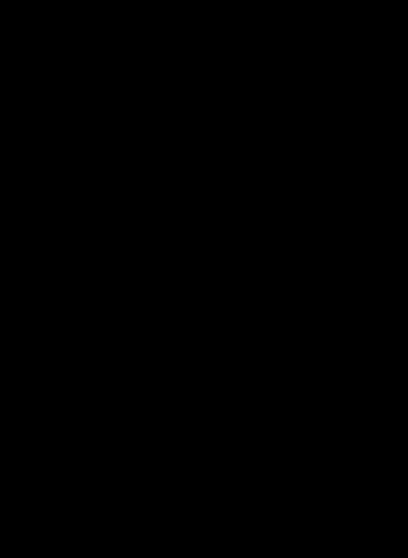

IMG_20240605_170657.jpg
IMG_20240605_170657.jpg
area 1.0
area 0.0
area 0.0
area 4.0
area 21.0
area 0.5
area 2.0
area 17.0
area 1.0
area 0.0
area 0.0
area 0.0
area 8.5
area 42.0
-131
area 0.0
area 3.0
area 2.0
area 3.0
area 0.0
area 0.0
area 1.0
area 0.5
area 1.5
area 4.0
area 1.0
area 15.5
area 6.0
area 3.5
area 0.0
area 0.0
area 6.0
area 1.0
area 50.5
-131
area 2.5
area 0.5
area 26.5
area 0.0
area 0.0
area 2.0
area 3.0
area 0.0
area 33.0
area 0.5
area 0.0
area 2.0
area 17.0
area 4.5
area 0.5
area 13.5
area 0.0
area 14.5
area 0.0
area 0.0
area 1.0
area 1.0
area 33.0
area 13.0
area 1.0
area 0.0
area 1.0
area 22.5
area 8.0
area 8.5
area 0.0
area 3.5
area 0.5
area 11.5
area 0.0
area 3.0
area 1.5
area 148.5
-131
area 0.5
area 4.5
area 1.5
area 0.5
area 2.0
area 0.5
area 1.5
area 2.5
area 6.0
area 5.5
area 2.5
area 0.5
area 3.5
area 11.5
area 11.5
area 2.5
area 14.5
area 4.5
area 1.5
area 3.5
area 0.5
area 1.0
area 0.0
area 1.5
area 0.0
area 0.5
area 12.5
area 1.5
area 22.5
area 1.5
area 2.

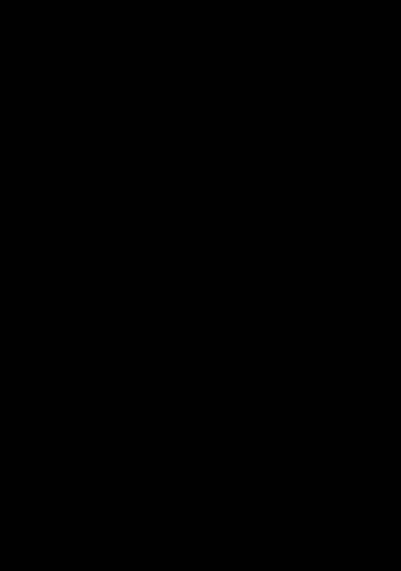

IMG_20240605_170659.jpg
IMG_20240605_170659.jpg
area 3.0
area 14.0
area 26.5
area 24.0
area 4.0
area 0.5
area 2.5
area 4.0
area 0.0
area 2.0
area 5.5
area 1.0
area 13.5
area 0.0
area 2.5
area 0.0
area 0.0
area 6.5
area 1.0
area 4.0
area 1.0
area 0.0
area 22.5
area 0.5
area 2.0
area 0.0
area 3.5
area 0.0
area 4.5
area 0.5
area 0.0
area 34.5
area 0.0
area 5.0
area 0.0
area 2.0
area 1.0
area 2.5
area 0.0
area 0.5
area 2.5
area 0.0
area 1.0
area 27.0
area 3.5
area 0.5
area 0.0
area 0.0
area 1.0
area 1.0
area 0.0
area 0.0
area 0.0
area 1.0
area 1.5
area 0.0
area 1.0
area 15.0
area 1.0
area 1.0
area 16.0
area 1.5
area 23.0
area 2.0
area 1.0
area 30.0
area 0.0
area 0.5
area 0.0
area 1.5
area 0.0
area 0.0
area 2.5
area 1.5
area 2.0
area 2.0
area 0.0
area 5.5
area 0.5
area 0.0
area 1.5
area 3.0
area 1.5
area 113.0
-98
area 1.5
area 0.0
area 1.0
area 0.0
area 0.0
area 18.0
area 1.0
area 1.0
area 5.5
area 3.5
area 0.0
area 1.5
area 3.5
area 2.0
area 19.0
area 0.0
area 0.0
area 1.0
area 0.0
area 3

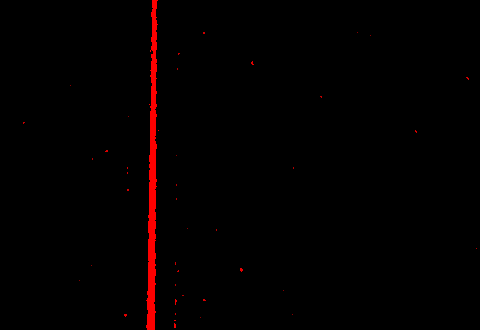

area 0.0
area 1051.0
area 1527.5
area 0.0
area 0.0
area 927.0
area 987.0
area 958.0
area 957.0
area 897.0
area 1.5
area 1047.5
area 1338.0
area 2518.5
area 3224.5
destra identificata
IMG_20240605_170702.jpg
IMG_20240605_170702.jpg
area 7.5
area 2.0
area 2.0
area 0.5
area 1.0
area 5.0
area 8.5
area 1.0
area 2.5
area 8.5
area 2.0
area 8.5
area 4.0
area 2.0
area 5.0
area 1.0
area 2.5
area 4.0
area 0.0
area 3.0
area 13.5
area 25.5
area 0.5
area 25.0
area 0.0
area 4.0
area 4.5
area 10.0
area 1.5
area 2.0
area 7.5
area 5.0
area 1.0
area 2.0
area 9.5
area 4.5
area 3.0
area 4.5
area 5.5
area 1.5
area 6.0
area 3.0
area 23.5
area 11.0
area 1.5
area 9.0
area 17.5
area 0.5
area 5.0
area 12.5
area 2.0
area 0.0
area 7.0
area 0.0
area 0.0
area 0.0
area 0.0
area 4.0
area 0.5
area 12.0
area 73.5
-136
area 5.0
area 0.0
area 88.5
-129
area 0.0
area 16.5
area 0.0
area 2.5
area 23.5
area 2.0
area 0.5
area 9.0
area 0.0
area 15.0
area 26.0
area 22.5
area 203.5
-61
area 39.5
area 13.0
area 5.0
area 0.0
area 6

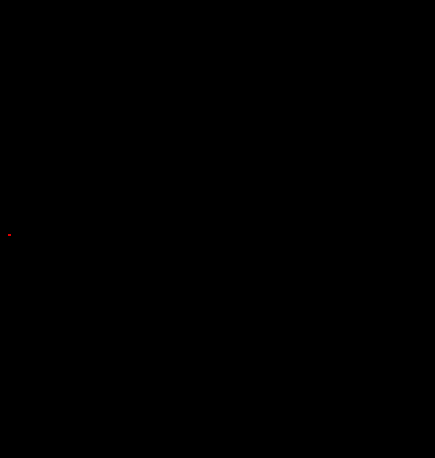

area 772.0
destra identificata
IMG_20240605_170707.jpg
IMG_20240605_170707.jpg
area 0.0
area 1.0
area 0.0
area 0.0
area 0.5
area 3.5
area 1.0
area 0.0
area 0.0
area 7.0
area 0.0
area 5.0
area 14.5
area 3.0
area 10.0
area 1.0
area 3.5
area 3.0
area 3.0
area 0.0
area 10.0
area 1.0
area 18.5
area 5.0
area 1.0
area 0.5
area 6.5
area 2.5
area 5.0
area 1.5
area 1.5
area 1.5
area 1.0
area 0.0
area 10.5
area 33.5
area 0.0
area 8.0
area 0.0
area 1.0
area 0.0
area 0.0
area 5.5
area 4.5
area 0.0
area 2.0
area 0.0
area 2.0
area 1.0
area 1.5
area 3.5
area 46.0
-103
area 1.0
area 0.5
area 3.0
area 2.0
area 4.0
area 1.0
area 0.5
area 1.0
area 1.0
area 0.5
area 19.0
area 2.5
area 1.0
area 1.5
area 4.0
area 3.5
area 0.5
area 0.0
area 1.0
area 0.0
area 0.0
area 0.5
area 5.0
area 1.0
area 5.0
area 0.0
area 0.0
area 7.0
area 3.0
area 1.5
area 1.5
area 2.5
area 4.5
area 1.0
area 2.0
area 3.0
area 21.0
area 0.5
area 1.5
area 4.0
area 46.0
-103
area 4.0
area 1.0
area 2.0
area 2.0
area 3.5
area 3.0
area 2.5
a

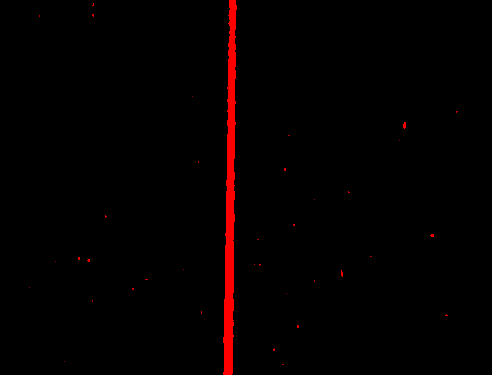

area 0.0
area 1921.5
area 986.0
area 927.0
area 1540.5
area 897.0
area 2942.0
area 1050.0
area 988.0
area 957.0
area 2799.5
area 927.0
area 1578.0
area 958.0
area 897.0
area 5170.0
area 1635.0
area 1.0
area 927.0
destra identificata
IMG_20240605_170710.jpg
IMG_20240605_170710.jpg
area 3.5
area 4.5
area 1.0
area 11.0
area 3.5
area 3.5
area 87.5
-63
area 23.0
area 4.0
area 0.0
area 10.0
area 0.0
area 5.0
area 0.0
area 10.0
area 0.0
area 9.5
area 1.5
area 8.5
area 3.0
area 73.0
-73
area 2.0
area 0.0
area 13.5
area 4.5
area 14.5
area 11.0
area 1.0
area 0.0
area 10.5
area 2.0
area 6.5
area 2.5
area 5.0
area 1.5
area 19.0
area 4.0
area 2.0
area 53.5
-146
area 20.0
area 2.5
area 7.5
area 2.0
area 9.5
area 30.0
area 3.5
area 107.5
-143
area 36.5
area 2.5
area 3.0
area 0.0
area 18.5
area 46.5
-113
area 2.5
area 0.5
area 7.5
area 0.0
area 7.5
area 74.0
-66
area 21.0
area 4.5
area 0.0
area 0.0
area 0.0
area 12.0
area 0.0
area 3.5
area 3.0
area 0.0
area 34.0
area 25.5
area 4.0
area 0.5
area 10.5
a

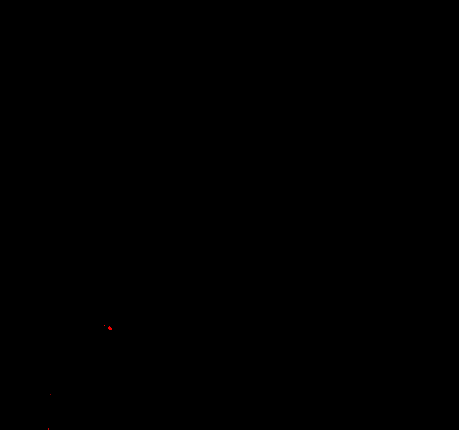

area 0.0
area 897.0
area 1203.0
destra identificata
IMG_20240605_170714.jpg
IMG_20240605_170714.jpg
area 0.0
area 0.0
area 0.0
area 6.0
area 0.0
area 0.5
area 7.5
area 2.0
area 0.0
area 2.5
area 19.0
area 25.5
area 0.5
area 2.0
area 0.0
area 18.5
area 1.0
area 1.0
area 0.0
area 1.0
area 1.0
area 4.0
area 9.5
area 0.0
area 1.0
area 1.0
area 0.0
area 1.5
area 0.0
area 42.5
-113
area 3.0
area 0.5
area 1.0
area 1.0
area 29.0
area 10.5
area 2.5
area 2.0
area 0.0
area 1.5
area 0.0
area 0.0
area 5.0
area 1.0
area 2.5
area 3.0
area 4.0
area 9.0
area 51.0
-113
area 1.5
area 0.0
area 3.0
area 0.0
area 0.5
area 0.0
area 4.5
area 0.0
area 0.0
area 52.0
-111
area 5.0
area 0.0
area 3.0
area 3.0
area 0.5
area 1.0
area 15.0
area 5.5
area 3.0
area 1.0
area 1.0
area 9.0
area 0.0
area 9.5
area 6.5
area 7.5
area 5.5
area 0.0
area 4.0
area 7.0
area 7.5
area 3.5
area 2.0
area 78.5
-113
area 2.0
area 0.5
area 1.0
area 0.0
area 1.0
area 5.0
area 5.0
area 6.0
area 6.5
area 2.0
area 3.5
area 3.0
area 1.5
area 4

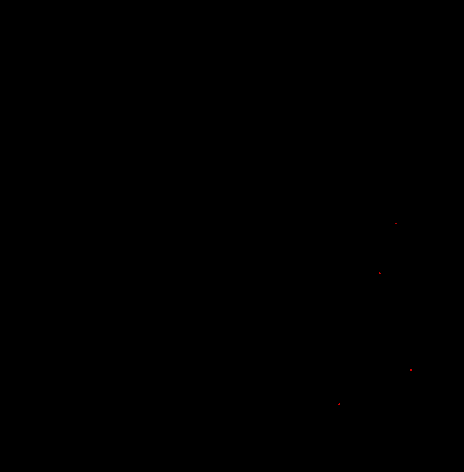

area 956.0
area 958.0
area 957.0
area 927.0
destra identificata
IMG_20240605_170716.jpg
IMG_20240605_170716.jpg
area 20.5
area 3.5
area 37.5
area 11.5
area 16.5
area 9.0
area 11.0
area 57.5
-153
area 0.5
area 4.0
area 7.0
area 15.5
area 0.0
area 3.0
area 5.0
area 0.0
area 2.0
area 11.5
area 0.0
area 4.0
area 6.5
area 1.0
area 0.5
area 2.5
area 0.5
area 0.5
area 12.0
area 0.0
area 2.0
area 0.5
area 0.0
area 2.5
area 2.0
area 20.5
area 1.0
area 0.0
area 69.0
-147
area 12.0
area 0.5
area 4.0
area 0.0
area 23.5
area 0.0
area 16.0
area 9.0
area 2.0
area 0.0
area 2.0
area 4.5
area 4.0
area 31.0
area 1.0
area 30.5
area 5.5
area 3.5
area 3.5
area 8.0
area 0.0
area 0.5
area 5.0
area 2.5
area 0.0
area 2.5
area 22.0
area 6.5
area 9.5
area 42.5
-148
area 6.5
area 3.5
area 25.0
area 20.0
area 0.0
area 17.0
area 5.5
area 3.0
area 0.0
area 32.5
area 0.0
area 0.5
area 3.0
area 0.0
area 0.0
area 0.5
area 0.0
area 26.0
area 2.0
area 87.0
-147
area 0.0
area 0.5
area 2.5
area 5.0
area 5.0
area 4.0
area 4.

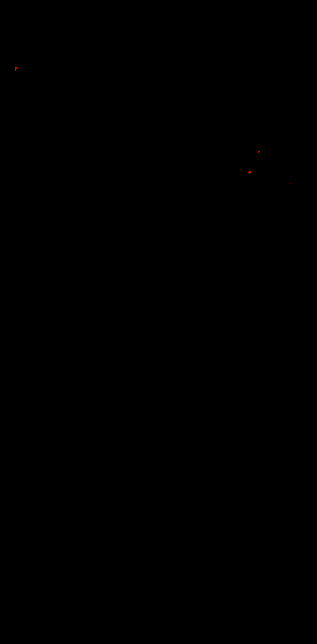

area 897.0
area 1737.5
area 1019.5
destra identificata
IMG_20240605_170720.jpg
IMG_20240605_170720.jpg
area 1.0
area 2.5
area 4.0
area 24.5
area 27.0
area 23.5
area 34.0
area 21.5
area 17.5
area 51.5
-95
area 3.0
area 24.5
area 21.5
area 1.0
area 19.5
area 3.0
area 1.0
area 1.0
area 27.0
area 30.5
area 2.5
area 24.0
area 7.5
area 2.0
area 0.5
area 9.0
area 28.5
area 6.5
area 9.0
area 0.0
area 2.5
area 5.5
area 1.0
area 3.0
area 3.0
area 0.5
area 4.0
area 0.0
area 8.0
area 0.5
area 7.0
area 0.0
area 0.5
area 1.0
area 1.0
area 4.0
area 0.5
area 0.5
area 16.0
area 2.0
area 24.5
area 0.0
area 0.0
area 39.0
area 8.5
area 0.0
area 0.0
area 1.5
area 41.0
-80
area 0.0
area 0.0
area 5.5
area 2.5
area 0.5
area 0.0
area 4.0
area 1.0
area 9.0
area 3.0
area 0.0
area 1.5
area 5.0
area 1.5
area 8.5
area 24.0
area 0.0
area 0.5
area 0.0
area 17.5
area 17.0
area 0.0
area 5.0
area 1.0
area 0.5
area 1.0
area 0.0
area 3.5
area 2.5
area 0.5
area 0.0
area 57.0
-164
area 6.0
area 0.0
area 2.0
area 2.0
area 0.

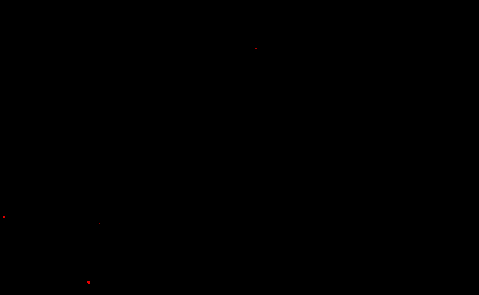

area 0.0
area 897.0
area 585.0
area 927.0
destra identificata
IMG_20240605_170723.jpg
IMG_20240605_170723.jpg
area 5.5
area 3.0
area 14.0
area 2.5
area 0.0
area 5.0
area 0.0
area 0.0
area 0.0
area 0.0
area 8.5
area 3.5
area 4.5
area 3.5
area 3.5
area 5.0
area 0.5
area 4.0
area 1.5
area 1.0
area 1.5
area 0.5
area 8.0
area 20.5
area 1.0
area 17.0
area 27.5
area 7.0
area 19.5
area 9.0
area 2.0
area 16.0
area 0.0
area 3.0
area 0.5
area 2.5
area 19.5
area 0.5
area 0.5
area 0.0
area 1.5
area 14.0
area 47.0
-52
area 1.5
area 3.0
area 4.0
area 1.5
area 1.5
area 0.0
area 2.0
area 2.0
area 24.5
area 0.0
area 18.0
area 0.5
area 0.0
area 0.5
area 4.5
area 0.0
area 2.0
area 4.0
area 35.5
area 1.0
area 27.5
area 0.0
area 4.0
area 20.0
area 0.5
area 1.5
area 0.0
area 3.0
area 0.5
area 3.5
area 84.5
-107
area 39.0
area 0.0
area 0.0
area 15.5
area 3.0
area 2.5
area 72.5
-51
area 0.0
area 1.0
area 3.0
area 0.5
area 24.5
area 16.5
area 2.5
area 1.0
area 16.5
area 1.0
area 6.0
area 3.0
area 1.0
area 34.5


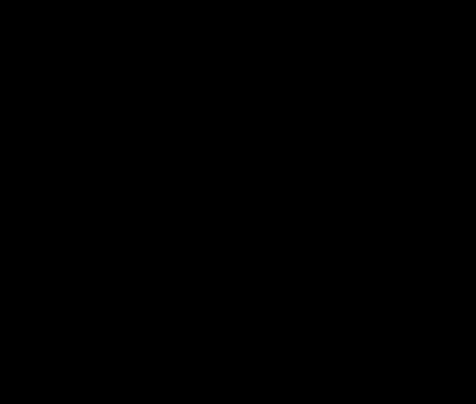

IMG_20240605_170733.jpg
IMG_20240605_170733.jpg
area 1.5
area 15.5
area 0.0
area 4.0
area 10.0
area 2.0
area 18.0
area 13.5
area 44.5
-109
area 0.5
area 0.5
area 1.0
area 36.5
area 0.0
area 2.5
area 0.0
area 41.5
-113
area 0.0
area 0.0
area 9.0
area 0.0
area 15.5
area 50.5
-113
area 0.0
area 4.0
area 3.0
area 0.0
area 4.0
area 0.0
area 25.5
area 0.0
area 4.0
area 0.0
area 21.5
area 0.0
area 3.0
area 0.0
area 16.5
area 133.5
-113
area 13.5
area 0.0
area 0.0
area 2.0
area 0.5
area 4.5
area 25.0
area 3.0
area 1.0
area 1.0
area 0.0
area 0.0
area 129.0
-113
area 21.5
area 1.0
area 1.0
area 0.0
area 0.0
area 72.0
-115
area 0.0
area 0.0
area 0.5
area 0.0
area 0.0
area 0.0
area 0.0
area 1.0
area 0.0
area 0.0
area 0.0
area 0.0
area 3.0
area 21.5
area 1.0
area 3.5
area 0.0
area 50.0
-113
area 0.0
area 1.0
area 0.5
area 2.0
area 0.0
area 7.5
area 1.0
area 0.0
area 0.0
area 9.5
area 3.5
area 0.5
area 12.5
area 33.0
area 22.5
area 62.5
-113
area 0.0
area 0.0
area 0.0
area 0.0
area 10.0
area 2.0
are

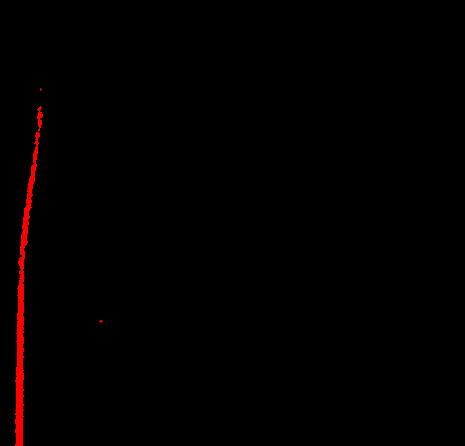

area 1048.5
area 8.0
destra identificata
IMG_20240605_170738.jpg
IMG_20240605_170738.jpg
area 0.0
area 2.0
area 3.5
area 1.0
area 18.5
area 4.5
area 44.5
-198
area 0.0
area 0.0
area 13.0
area 0.0
area 1.0
area 74.0
-138
area 39.0
area 1.5
area 2.0
area 0.0
area 0.5
area 0.0
area 0.5
area 2.0
area 1.5
area 0.5
area 0.0
area 0.0
area 0.0
area 0.5
area 93.5
-138
area 0.0
area 11.0
area 2.0
area 0.0
area 4.5
area 0.0
area 24.5
area 0.0
area 150.0
-138
area 7.0
area 4.5
area 3.5
area 0.5
area 1.0
area 15.0
area 6.5
area 6.0
area 0.0
area 0.0
area 0.0
area 0.0
area 5.5
area 3.0
area 0.0
area 0.0
area 0.5
area 2.5
area 70.0
-137
area 0.0
area 5.0
area 33.5
area 1.5
area 341.5
-138
area 0.5
area 0.5
area 0.0
area 0.5
area 15.0
area 0.0
area 0.0
area 0.5
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 2.5
area 3.0
area 4.0
area 42.5
-210
area 7.5
area 27.5
area 1.5
area 0.5
area 0.0
area 0.5
area 346.0
-138
area 1.5
area 0.0
area 0.0
area 0.0
area 1.0
area 0.0
area 1.0
area 0.5
area 349.0
-13

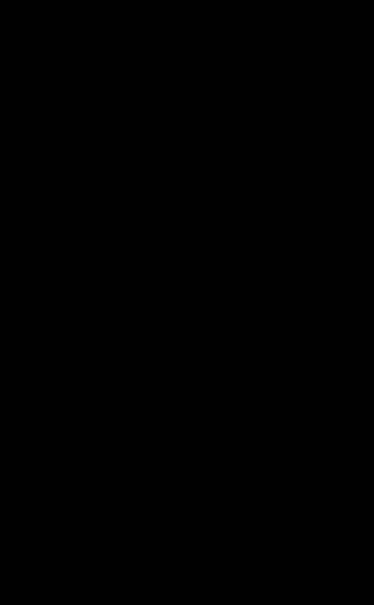

IMG_20240605_170740.jpg
IMG_20240605_170740.jpg
area 0.0
area 0.0
area 2.5
area 2.5
area 3.0
area 10.0
area 14.5
area 22.5
area 3.0
area 8.0
area 2.5
area 31.5
area 7.0
area 4.0
area 0.0
area 0.0
area 1.0
area 87.0
-161
area 18.5
area 8.0
area 17.5
area 2.0
area 27.0
area 2.5
area 27.5
area 3.0
area 2.0
area 2.5
area 0.5
area 13.0
area 0.0
area 0.0
area 1.0
area 1.5
area 0.5
area 0.0
area 0.0
area 0.5
area 0.0
area 0.0
area 32.5
area 2.0
area 1.0
area 0.0
area 0.0
area 59.5
-159
area 1.0
area 0.0
area 0.0
area 0.0
area 0.0
area 42.5
-159
area 0.0
area 13.5
area 6.5
area 0.5
area 1.0
area 0.0
area 19.5
area 0.0
area 0.0
area 1.5
area 11.0
area 3.5
area 0.0
area 1.0
area 3.5
area 0.0
area 120.5
-159
area 0.0
area 0.0
area 2.0
area 8.5
area 23.0
area 0.0
area 1.0
area 11.0
area 22.0
area 0.0
area 1.0
area 3.0
area 0.0
area 0.0
area 12.5
area 49.5
-159
area 0.0
area 0.5
area 0.0
area 0.0
area 17.0
area 1.0
area 3.0
area 1.0
area 8.0
area 3.5
area 15.5
area 4.0
area 1.5
area 0.0
area 0.0
ar

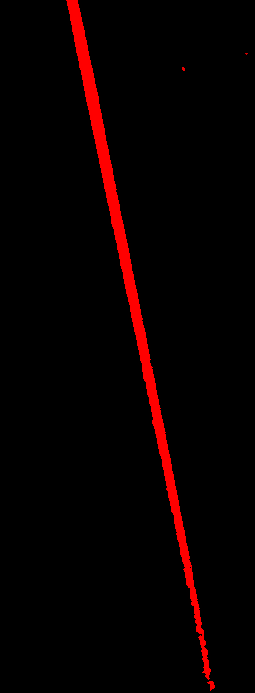

area 1051.0
area 0.5
area 5.5
area 4.5
destra identificata
IMG_20240605_170743.jpg
IMG_20240605_170743.jpg
area 0.0
area 0.0
area 2.5
area 1.5
area 1.5
area 0.0
area 7.5
area 0.0
area 13.0
area 2.0
area 1.5
area 37.0
area 0.0
area 4.0
area 1.0
area 25.0
area 1.0
area 0.0
area 1.5
area 6.5
area 1.0
area 2.0
area 0.5
area 14.0
area 0.0
area 0.5
area 10.0
area 1.0
area 37.0
area 0.0
area 8.0
area 9.0
area 2.0
area 1.0
area 0.0
area 68.0
-119
area 9.5
area 15.5
area 16.5
area 1.0
area 6.5
area 4.5
area 0.0
area 0.5
area 1.0
area 5.0
area 0.0
area 21.0
area 4.5
area 0.0
area 5.0
area 1.5
area 1.0
area 0.0
area 12.0
area 1.0
area 63.5
-119
area 48.0
-116
area 0.5
area 4.0
area 1.0
area 10.5
area 3.0
area 75.5
-118
area 56.0
-118
area 2.5
area 242.5
-118
area 37.0
area 7.0
area 87.5
-118
area 12.5
area 12.0
area 4.5
area 4.0
area 0.0
area 1.5
area 31.5
area 2.0
area 0.0
area 1.0
area 1.0
area 5.0
area 0.0
area 6.0
area 252.0
-118
area 253.0
-119
area 0.0
area 9.0
area 0.0
area 0.0
area 2.0
ar

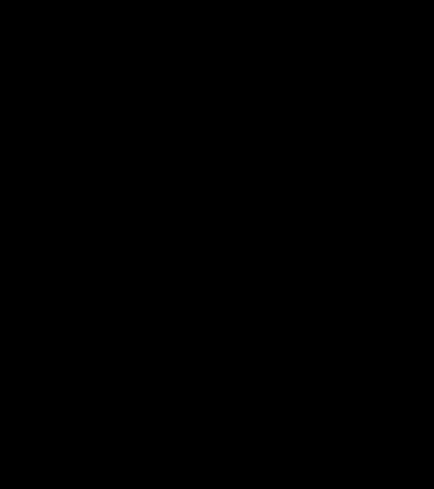

IMG_20240605_170747.jpg
IMG_20240605_170747.jpg
area 0.0
area 0.0
area 0.0
area 0.0
area 3.0
area 3.5
area 0.5
area 0.5
area 1.0
area 3.0
area 0.0
area 0.0
area 3.5
area 1.0
area 0.0
area 37.5
area 0.5
area 1.5
area 3.0
area 1.0
area 0.0
area 0.0
area 6.0
area 0.5
area 0.0
area 16.5
area 0.0
area 0.0
area 0.5
area 0.5
area 8.0
area 0.0
area 26.5
area 4.0
area 13.5
area 0.0
area 0.0
area 0.5
area 0.5
area 0.0
area 12.5
area 0.0
area 125.5
-107
area 0.0
area 0.0
area 0.0
area 33.0
area 6.5
area 0.0
area 1.0
area 8.0
area 0.0
area 9.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 85.5
-113
area 0.5
area 2.0
area 71.5
-114
area 0.5
area 0.0
area 10.5
area 1.0
area 0.0
area 0.5
area 1.0
area 0.0
area 67.5
-113
area 0.0
area 0.0
area 48.5
-113
area 2.5
area 0.5
area 0.0
area 3.0
area 27.0
area 0.0
area 123.0
-113
area 4.0
area 0.0
area 39.0
area 3.0
area 2.0
area 0.0
area 0.5
area 0.0
area 1.0
area 0.0
area 119.5
-113
area 109.0
-112
area 30.0
area 0.0
area 0.0
area 10.0
area 1.

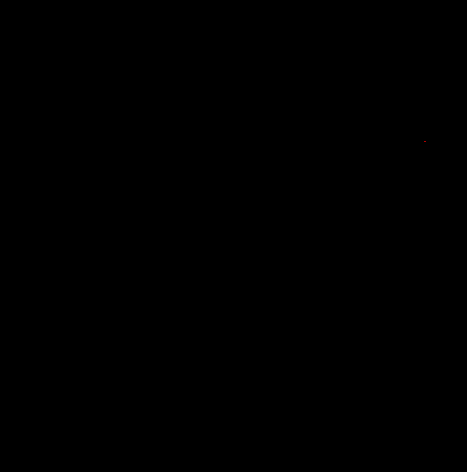

area 927.0
destra identificata
IMG_20240605_170750.jpg
IMG_20240605_170750.jpg
area 0.0
area 1.0
area 1.5
area 0.0
area 3.0
area 0.0
area 0.0
area 0.5
area 21.5
area 2.0
area 5.5
area 1.0
area 0.0
area 0.5
area 10.5
area 5.5
area 1.5
area 2.5
area 4.0
area 1.5
area 1.0
area 10.5
area 2.0
area 1.5
area 2.0
area 0.0
area 2.0
area 7.5
area 2.0
area 0.0
area 1.5
area 7.0
area 2.0
area 1.5
area 3.0
area 13.0
area 4.5
area 0.0
area 0.0
area 12.5
area 0.0
area 2.0
area 0.0
area 6.5
area 5.5
area 0.0
area 2.0
area 0.0
area 4.5
area 1.0
area 3.5
area 0.0
area 3.5
area 14.5
area 0.0
area 1.0
area 3.0
area 3.0
area 1.5
area 2.5
area 5.0
area 0.0
area 0.0
area 0.0
area 0.5
area 0.0
area 6.0
area 0.0
area 0.0
area 8.0
area 2.5
area 19.5
area 2.0
area 0.5
area 39.5
area 1.5
area 3.0
area 2.0
area 1.0
area 0.0
area 10.5
area 1.0
area 4.0
area 0.0
area 0.0
area 0.0
area 0.0
area 16.0
area 17.5
area 7.5
area 9.0
area 0.5
area 0.0
area 7.5
area 0.0
area 0.5
area 5.0
area 1.0
area 0.0
area 0.0
area 0.0
a

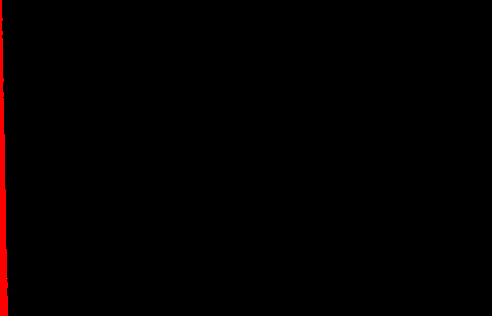

area 0.0
area 0.0
IMG_20240605_170755.jpg
IMG_20240605_170755.jpg
area 2.5
area 2.0
area 4.5
area 1.5
area 1.0
area 20.0
area 2.0
area 5.5
area 16.0
area 4.5
area 5.5
area 7.5
area 3.5
area 35.0
area 53.0
-133
area 10.5
area 3.5
area 13.5
area 14.5
area 3.0
area 2.0
area 9.5
area 1.0
area 3.5
area 9.5
area 3.0
area 6.0
area 81.0
-219
area 8.0
area 55.0
-58
area 3.0
area 3.5
area 1.5
area 36.0
area 2.5
area 3.0
area 20.0
area 10.0
area 19.0
area 6.0
area 6.5
area 4.0
area 1.5
area 3.0
area 3.0
area 31.0
area 5.0
area 0.5
area 22.5
area 2.0
area 35.0
area 0.0
area 16.0
area 30.5
area 2.0
area 10.0
area 10.0
area 1.5
area 3.0
area 22.0
area 16.0
area 13.0
area 21.5
area 83.5
-60
area 1.5
area 32.0
area 6.0
area 2.0
area 0.5
area 28.0
area 24.0
area 5.0
area 6.0
area 2.5
area 1.0
area 4.0
area 26.0
area 2.0
area 2.5
area 17.5
area 9.5
area 2.5
area 17.5
area 6.0
area 33.0
area 5.5
area 18.0
area 6.0
area 24.0
area 15.5
area 2.5
area 0.0
area 36.5
area 6.5
area 0.5
area 1.0
area 88.5
-53
ar

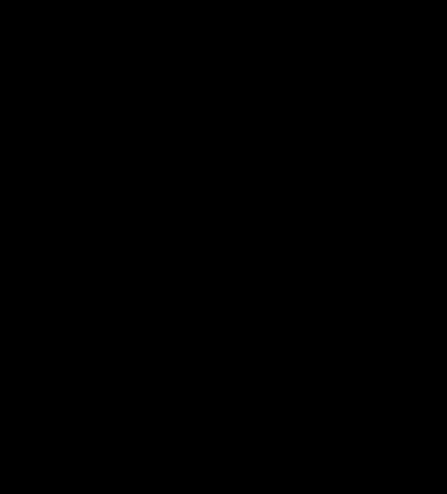

IMG_20240605_170757.jpg
IMG_20240605_170757.jpg
area 0.0
area 0.0
area 0.0
area 1.0
area 0.0
area 14.0
area 1.0
area 1.5
area 0.0
area 1214.0
-116
area 4.0
area 0.0
area 0.0
area 2.5
area 0.0
area 3.5
area 2.5
area 0.0
area 0.0
area 0.0
area 1.0
area 2.0
area 0.5
area 0.0
area 1.0
area 0.0
area 22.0
area 28.5
area 2.0
area 22.0
area 0.0
area 1.5
area 0.5
area 5.5
area 3.0
area 0.0
area 14.0
area 46.0
-99
area 0.0
area 0.0
area 1.5
area 0.5
area 0.0
area 2.0
area 0.0
area 0.0
area 3.5
area 4.0
area 4.0
area 0.0
area 0.0
area 1.0
area 0.0
area 1.0
area 2.5
area 1.5
area 0.0
area 0.5
area 19.5
area 0.0
area 4.0
area 3.0
area 0.0
area 4.0
area 0.0
area 3.5
area 1.0
area 0.0
area 44.0
-102
area 1.0
area 1.5
area 4.0
area 2.0
area 0.0
area 1.0
area 3.5
area 3.0
area 6.0
area 1.0
area 0.0
area 1.0
area 2.5
area 28.5
area 4.5
area 15.0
area 10.0
area 0.5
area 1.5
area 1.5
area 1.0
area 1.5
area 3.5
area 6.0
area 0.0
area 1.5
area 2.0
area 1.5
area 49.0
-102
area 1.0
area 10.5
area 3.5
area 3.5

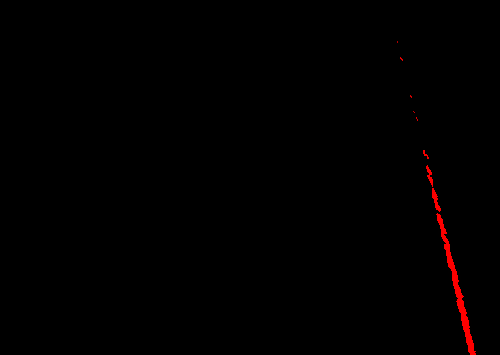

area 1840.5
area 1573.0
destra identificata
IMG_20240605_170800.jpg
IMG_20240605_170800.jpg
area 1.0
area 3.5
area 1245.0
-98
area 1.0
area 4.5
area 0.0
area 0.0
area 4.0
area 0.0
area 4.0
area 1.0
area 25.5
area 2.0
area 1.0
area 0.0
area 0.5
area 22.5
area 53.0
-144
area 4.5
area 0.0
area 1.0
area 3.0
area 0.0
area 6.0
area 0.0
area 0.0
area 15.0
area 5.0
area 0.0
area 10.0
area 9.5
area 0.0
area 0.5
area 5.0
area 0.0
area 14.0
area 36.0
area 9.0
area 15.5
area 2.5
area 1.5
area 3.5
area 12.0
area 0.0
area 2.0
area 0.5
area 6.5
area 1.5
area 26.5
area 3.0
area 7.5
area 3.0
area 1.5
area 1.5
area 2.0
area 46.5
-140
area 0.5
area 171.0
-142
area 4.0
area 1.5
area 3.0
area 1.5
area 0.5
area 11.5
area 0.0
area 20.5
area 0.0
area 4.0
area 5.5
area 11.5
area 1.0
area 4.5
area 1.0
area 3.0
area 1.5
area 1.0
area 0.0
area 1.5
area 1.5
area 1.0
area 4.0
area 7.0
area 1.0
area 1.5
area 3.5
area 1.0
area 2.5
area 19.0
area 4.5
area 4.5
area 2.5
area 0.0
area 2.5
area 0.0
area 11.5
area 0.0
area

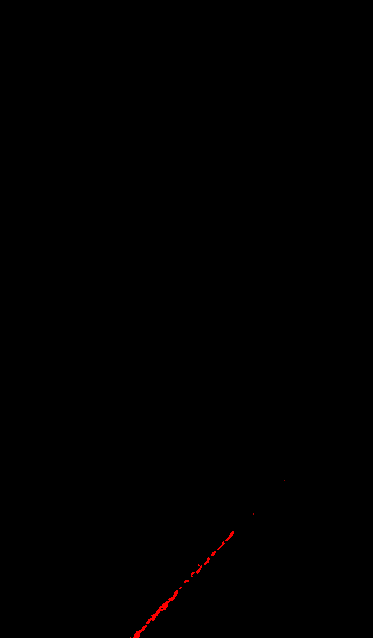

area 854.0
area 897.0
destra identificata
IMG_20240605_170805.jpg
IMG_20240605_170805.jpg
area 0.0
area 3.5
area 0.0
area 6.5
area 0.0
area 0.0
area 0.5
area 9.5
area 2.0
area 0.5
area 10.0
area 59.5
-60
area 6.5
area 22.5
area 10.0
area 14.0
area 4.5
area 52.5
-134
area 21.0
area 2.0
area 0.5
area 8.0
area 50.0
-139
area 92.0
-139
area 10.0
area 9.5
area 21.5
area 1.5
area 20.0
area 21.0
area 22.0
area 5.5
area 124.5
-58
area 40.0
area 24.0
area 2.0
area 8.5
area 20.0
area 4.0
area 10.5
area 6.5
area 9.0
area 1.5
area 2.0
area 6.0
area 9.0
area 9.0
area 32.0
area 28.5
area 6.5
area 3.0
area 4.5
area 5.0
area 24.0
area 1.5
area 20.0
area 46.0
-54
area 7.0
area 19.0
area 2.0
area 1.5
area 212.0
-54
area 6.0
area 2.5
area 1.0
area 17.0
area 23.0
area 23.5
area 9.0
area 0.0
area 1.0
area 0.0
area 5.0
area 0.0
area 0.5
area 15.5
area 6.0
area 1.5
area 0.0
area 0.5
area 0.5
area 2.0
area 5.0
area 0.0
area 2.5
area 4.5
area 78.0
-54
area 1.5
area 10.5
area 2.0
area 0.0
area 0.0
area 1.5
area

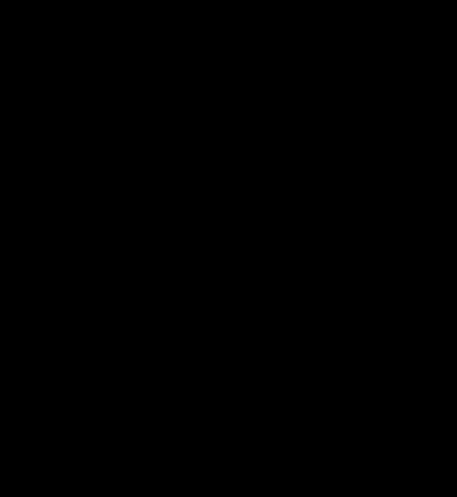

IMG_20240605_170808.jpg
IMG_20240605_170808.jpg
area 0.0
area 0.0
area 0.0
area 9.0
area 2.5
area 1.0
area 4.5
area 2.5
area 2.0
area 0.0
area 0.0
area 0.0
area 15.0
area 5.5
area 2.0
area 3.0
area 0.0
area 19.5
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.5
area 0.0
area 0.5
area 0.0
area 7.0
area 0.0
area 3.0
area 2.0
area 2.0
area 0.5
area 0.0
area 1.0
area 2.0
area 0.5
area 0.5
area 21.5
area 1.0
area 0.0
area 9.5
area 4.0
area 1.0
area 0.0
area 3.5
area 0.0
area 4.5
area 0.5
area 2.5
area 0.0
area 0.0
area 0.0
area 1.0
area 33.0
area 0.0
area 0.0
area 2.5
area 0.0
area 1.0
area 0.0
area 0.0
area 0.0
area 0.0
area 2.0
area 0.0
area 19.5
area 1.0
area 13.0
area 0.0
area 3.0
area 1.0
area 0.0
area 3.5
area 6.0
area 0.0
area 0.0
area 4.0
area 1.5
area 2.5
area 2.0
area 10.0
area 1.0
area 2.0
area 1.5
area 15.0
area 3.0
area 11.0
area 3.0
area 3.0
area 4.5
area 0.0
area 4.5
area 1.0
area 1.5
area 1.0
area 1.5
area 2.5
area 3.5
area 1.5
area 50.5
-100
area 2.0
area 0.0
area 1.5
a

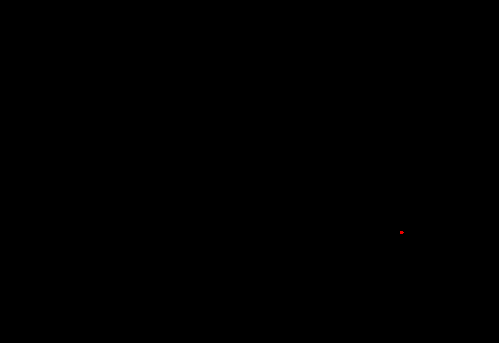

area 1052.0
destra identificata
IMG_20240605_170810.jpg
IMG_20240605_170810.jpg
area 3.0
area 13.5
area 5.5
area 3.5
area 8.0
area 16.0
area 12.0
area 8.0
area 6.5
area 15.0
area 1.0
area 0.0
area 3.5
area 55.0
-121
area 0.0
area 69.0
-119
area 2.0
area 0.0
area 21.5
area 43.0
-119
area 7.0
area 0.0
area 0.0
area 3.0
area 12.0
area 0.0
area 7.0
area 0.0
area 1.5
area 0.0
area 0.5
area 0.0
area 0.5
area 54.5
-120
area 0.0
area 1.5
area 52.5
-120
area 21.5
area 0.0
area 0.0
area 0.0
area 1.0
area 0.0
area 13.0
area 0.5
area 18.0
area 0.0
area 2.0
area 36.0
area 0.0
area 0.0
area 0.0
area 9.5
area 1.0
area 0.5
area 1.0
area 14.5
area 0.0
area 27.5
area 0.0
area 0.0
area 1.5
area 13.0
area 0.0
area 15.0
area 0.5
area 0.0
area 1.0
area 28.0
area 4.0
area 1.0
area 22.0
area 11.5
area 1.0
area 1.0
area 1.0
area 9.0
area 0.0
area 0.0
area 2.0
area 0.0
area 0.0
area 0.0
area 56.5
-118
area 1.0
area 0.0
area 0.0
area 11.5
area 0.0
area 0.0
area 38.0
area 0.0
area 1.0
area 0.5
area 1.5
area 0.0
a

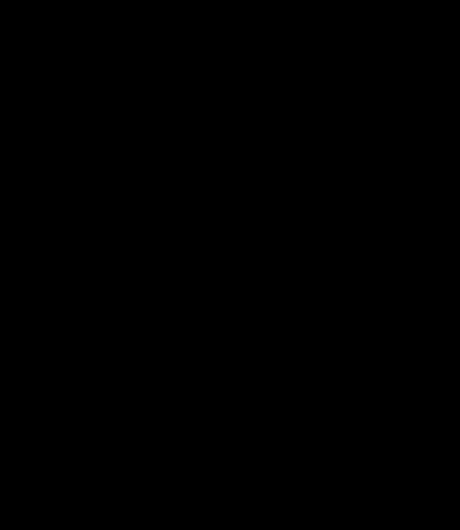

IMG_20240605_170813.jpg
IMG_20240605_170813.jpg
area 0.0
area 1.5
area 6.0
area 0.5
area 23.5
area 3.5
area 3.0
area 1.0
area 9.5
area 7.0
area 0.0
area 16.0
area 0.0
area 0.0
area 29.5
area 10.0
area 1.5
area 7.0
area 13.0
area 5.5
area 6.0
area 31.5
area 2.0
area 6.0
area 9.5
area 0.0
area 1.0
area 16.5
area 0.0
area 9.0
area 1.0
area 10.5
area 2.0
area 0.0
area 21.0
area 0.0
area 10.0
area 51.5
-149
area 0.5
area 0.0
area 0.0
area 3.0
area 1.5
area 0.0
area 0.0
area 15.0
area 13.5
area 0.0
area 0.0
area 1.5
area 7.5
area 0.5
area 3.0
area 2.5
area 16.0
area 0.0
area 0.0
area 0.0
area 0.5
area 13.0
area 34.5
area 0.0
area 0.0
area 19.5
area 0.0
area 6.5
area 0.0
area 0.0
area 1.0
area 7.0
area 14.0
area 1.5
area 0.5
area 2.0
area 4.5
area 0.0
area 0.0
area 0.0
area 20.0
area 1.5
area 2.0
area 3.0
area 0.0
area 0.0
area 3.5
area 0.0
area 0.0
area 1.0
area 0.0
area 16.5
area 1.0
area 0.0
area 2.5
area 1.0
area 10.0
area 1.5
area 0.5
area 2.5
area 0.0
area 1.0
area 0.0
area 3.0
area 3.0

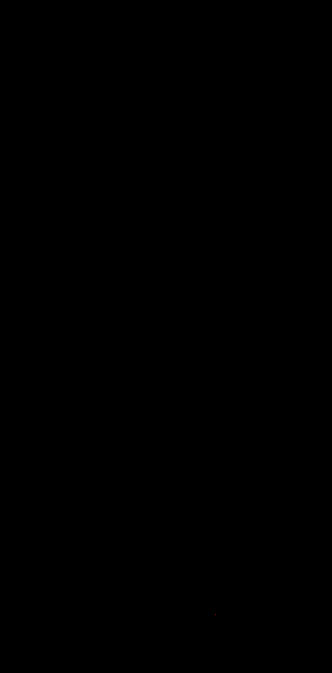

area 897.0
destra identificata
IMG_20240605_170816.jpg
IMG_20240605_170816.jpg
area 4.0
area 4.5
area 0.0
area 2.5
area 1.0
area 1.5
area 0.0
area 0.0
area 14.0
area 0.0
area 0.0
area 4.0
area 0.0
area 0.0
area 0.0
area 60.0
-96
area 2.0
area 0.0
area 4.5
area 1.5
area 0.5
area 7.0
area 1.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 1.0
area 2.0
area 0.0
area 0.0
area 31.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 1.5
area 13.5
area 0.0
area 0.0
area 0.0
area 0.0
area 0.5
area 0.0
area 6.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 6.5
area 0.0
area 1.5
area 0.0
area 4.0
area 1.0
area 3.5
area 2.0
area 2.5
area 1.0
area 26.0
area 2.0
area 6.5
area 1.0
area 1.0
area 4.0
area 2.0
area 8.5
area 6.0
area 7.0
area 1.5
area 3.5
area 58.0
-100
area 35.0
area 43.0
-105
area 6.0
area 1.5
area 81.0
-101
area 23.5
area 0.0
area 2.5
area 0.0
area 10.0
area 0.0
area 1.0
area 1.5
area 0.0
area 1.0
area 1.5
area 3.0
area 1.5
area 1.5
area 1.5


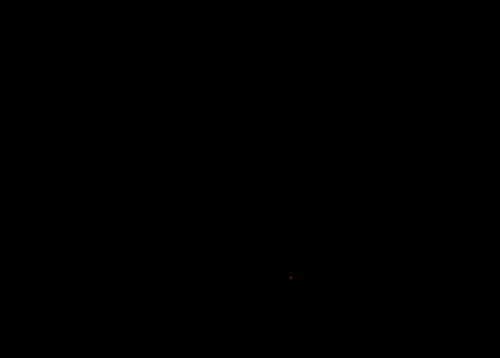

area 957.0
destra identificata
IMG_20240605_170818.jpg
IMG_20240605_170818.jpg
area 2.5
area 1.5
area 8.5
area 0.0
area 5.5
area 18.0
area 39.5
area 11.5
area 4.0
area 2.0
area 0.5
area 5.5
area 6.0
area 11.0
area 8.0
area 2.5
area 21.0
area 14.5
area 1.5
area 1.0
area 1.5
area 1.5
area 12.0
area 0.5
area 44.0
-144
area 1.0
area 1.0
area 11.0
area 10.0
area 3.5
area 9.0
area 1.0
area 14.5
area 0.0
area 5.0
area 1.5
area 3.0
area 13.5
area 1.5
area 6.5
area 0.0
area 0.0
area 1.5
area 55.0
-67
area 11.5
area 7.5
area 2.5
area 21.0
area 53.0
-151
area 0.0
area 11.0
area 13.0
area 17.0
area 5.0
area 29.5
area 2.5
area 21.0
area 0.5
area 6.5
area 0.0
area 5.0
area 5.0
area 3.5
area 7.0
area 4.5
area 4.5
area 5.5
area 13.0
area 12.0
area 11.5
area 20.0
area 1.5
area 28.5
area 6.5
area 1.0
area 78.0
-65
area 17.5
area 6.5
area 16.5
area 0.0
area 33.0
area 17.0
area 0.0
area 0.0
area 3.5
area 179.0
-65
area 0.0
area 36.5
area 0.0
area 249.5
-65
area 1.0
area 0.0
area 0.0
area 17.0
area 4.0
are

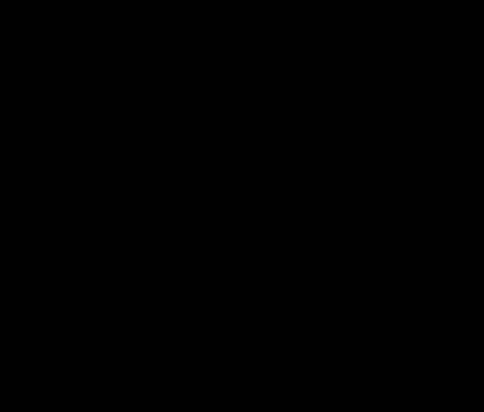

IMG_20240605_170824.jpg
IMG_20240605_170824.jpg
area 8.0
area 2.5
area 1.0
area 15.5
area 3.5
area 11.0
area 5.0
area 14.5
area 1.0
area 3.5
area 4.5
area 16.5
area 1.0
area 1.0
area 0.5
area 9.0
area 0.5
area 4.5
area 5.0
area 6.0
area 5.5
area 6.5
area 9.5
area 8.0
area 10.5
area 2.5
area 2.0
area 11.0
area 0.0
area 49.5
-133
area 2.5
area 5.0
area 8.0
area 9.0
area 6.5
area 1.5
area 74.0
-131
area 9.0
area 12.5
area 15.0
area 13.5
area 11.5
area 2.5
area 14.5
area 7.5
area 5.0
area 26.5
area 2.0
area 38.5
area 1.5
area 2.0
area 150.0
-57
area 6.0
area 8.5
area 4.0
area 6.0
area 5.0
area 4.0
area 14.0
area 6.5
area 3.0
area 1.5
area 8.5
area 15.5
area 3.5
area 102.5
-52
area 8.5
area 3.5
area 32.0
area 6.0
area 21.5
area 7.0
area 6.0
area 0.5
area 1.0
area 2.0
area 19.5
area 7.0
area 22.5
area 5.5
area 14.0
area 3.0
area 5.5
area 16.5
area 18.5
area 5.5
area 1.0
area 4.0
area 25.5
area 48.5
-50
area 9.0
area 0.0
area 3.0
area 34.5
area 26.0
area 20.0
area 0.0
area 0.5
area 2.0
area 3

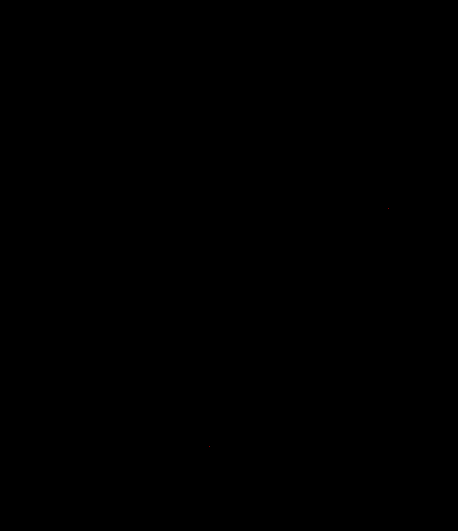

area 897.0
area 897.0
destra identificata
IMG_20240605_170833.jpg
IMG_20240605_170833.jpg
area 1.0
area 0.0
area 36.0
area 0.0
area 11.5
area 2.0
area 13.0
area 0.5
area 1.0
area 1.0
area 6.5
area 4.0
area 0.0
area 1.5
area 0.0
area 0.0
area 13.5
area 3.0
area 0.0
area 2.5
area 6.0
area 0.5
area 7.0
area 0.5
area 2.0
area 0.5
area 13.0
area 6.5
area 0.5
area 11.0
area 3.0
area 12.5
area 11.0
area 11.5
area 0.0
area 2.5
area 7.5
area 2.5
area 2.5
area 0.0
area 8.5
area 3.0
area 11.5
area 0.0
area 17.5
area 32.0
area 47.5
-144
area 7.0
area 5.0
area 1.0
area 16.5
area 5.5
area 0.0
area 3.0
area 5.0
area 54.5
-65
area 96.5
-138
area 3.5
area 7.0
area 0.5
area 8.5
area 66.0
-143
area 5.5
area 29.5
area 17.5
area 5.5
area 41.0
-62
area 15.5
area 2.5
area 0.0
area 12.5
area 0.0
area 1.0
area 0.0
area 0.0
area 58.0
-57
area 0.0
area 0.5
area 2.0
area 6.5
area 26.5
area 17.5
area 0.0
area 0.0
area 4.0
area 0.0
area 0.5
area 0.0
area 0.5
area 26.5
area 0.0
area 0.0
area 0.0
area 11.5
area 0.5
a

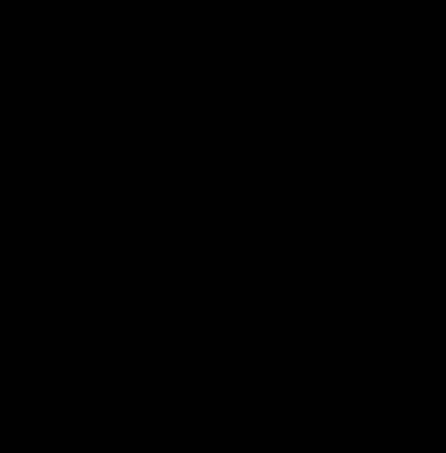

IMG_20240605_170838.jpg
IMG_20240605_170838.jpg
area 1.0
area 0.0
area 2.0
area 10.5
area 10.0
area 5.0
area 0.0
area 1.5
area 9.5
area 0.0
area 8.0
area 1.0
area 3.5
area 0.5
area 44.5
-108
area 6.0
area 0.0
area 6.0
area 30.5
area 6.5
area 6.0
area 24.5
area 0.5
area 7.0
area 20.5
area 13.5
area 0.0
area 4.0
area 8.0
area 42.5
-54
area 2.5
area 0.0
area 2.0
area 0.0
area 26.0
area 37.0
area 12.5
area 12.0
area 31.5
area 21.5
area 7.5
area 1.5
area 8.0
area 2.0
area 27.5
area 13.0
area 40.5
-51
area 14.5
area 9.5
area 16.5
area 1.0
area 0.0
area 0.0
area 3.0
area 37.5
area 15.5
area 0.0
area 2.5
area 0.5
area 9.0
area 1.5
area 12.5
area 0.0
area 14.0
area 3.5
area 9.5
area 79.0
-224
area 14.5
area 0.0
area 35.0
area 0.0
area 0.0
area 12.0
area 0.5
area 17.5
area 37.5
area 5.5
area 0.5
area 0.5
area 1.0
area 0.5
area 18.5
area 12.5
area 1.0
area 22.0
area 11.0
area 0.5
area 4.0
area 4.5
area 1.5
area 0.0
area 23.5
area 0.0
area 8.5
area 6.0
area 3.5
area 2.0
area 0.0
area 0.0
area 0.0


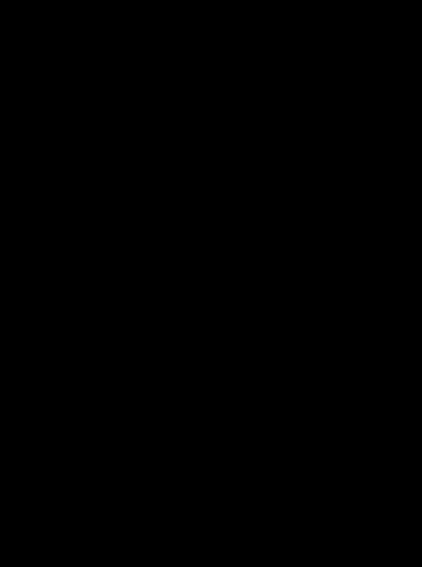

IMG_20240605_170840.jpg
IMG_20240605_170840.jpg
area 2.5
area 2.5
area 14.0
area 7.0
area 4.0
area 1.5
area 33.0
area 3.0
area 15.5
area 49.0
-126
area 4.0
area 2.5
area 54.5
-124
area 35.5
area 31.0
area 34.0
area 43.5
-124
area 8.5
area 5.0
area 20.5
area 17.0
area 7.5
area 23.0
area 5.0
area 22.0
area 0.0
area 5.5
area 8.5
area 2.0
area 15.0
area 6.5
area 1.0
area 24.5
area 9.5
area 49.0
-124
area 1.0
area 0.0
area 7.0
area 2.5
area 3.5
area 4.5
area 24.0
area 29.5
area 10.0
area 8.5
area 11.0
area 0.5
area 0.5
area 1.5
area 7.5
area 18.5
area 14.5
area 31.5
area 1.0
area 0.5
area 7.5
area 0.0
area 35.5
area 1.0
area 18.0
area 28.0
area 0.5
area 30.0
area 11.5
area 9.5
area 3.5
area 3.0
area 0.5
area 6.5
area 3.0
area 11.0
area 0.0
area 0.0
area 7.0
area 5.5
area 24.0
area 6.0
area 10.0
area 0.0
area 3.5
area 20.5
area 0.0
area 1.0
area 14.5
area 4.5
area 0.5
area 6.0
area 0.0
area 40.5
-124
area 4.0
area 0.0
area 20.5
area 23.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 19.5

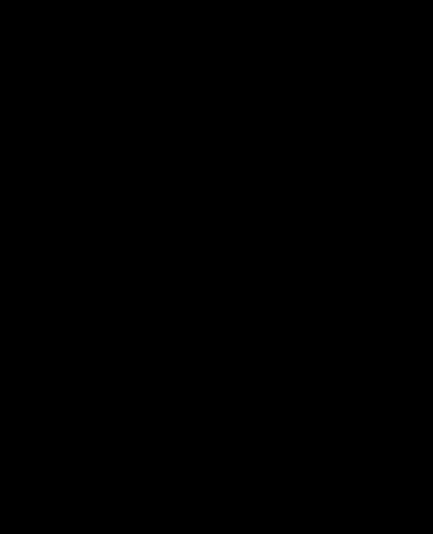

IMG_20240605_170845.jpg
IMG_20240605_170845.jpg
area 36.0
area 40.5
-120
area 9.0
area 5.5
area 8.0
area 3.5
area 14.5
area 6.0
area 9.0
area 2.0
area 14.5
area 2.5
area 10.5
area 5.5
area 21.5
area 10.5
area 3.0
area 5.0
area 1.5
area 17.0
area 2.0
area 7.0
area 10.5
area 2.5
area 17.5
area 1.5
area 5.0
area 4.0
area 6.0
area 1.5
area 6.5
area 1.0
area 0.5
area 9.0
area 1.0
area 2.5
area 9.0
area 5.0
area 0.0
area 7.0
area 18.0
area 3.0
area 7.5
area 4.0
area 3.0
area 26.5
area 1.0
area 1.0
area 4.0
area 16.0
area 0.0
area 20.0
area 4.0
area 0.5
area 0.0
area 0.0
area 0.0
area 3.5
area 0.0
area 0.0
area 0.0
area 0.0
area 8.0
area 0.0
area 37.0
area 3.5
area 0.0
area 0.0
area 0.5
area 0.0
area 1.5
area 0.0
area 2.0
area 0.0
area 0.0
area 0.0
area 0.5
area 3.5
area 63.0
-108
area 2.0
area 0.0
area 5.5
area 0.0
area 0.0
area 4.0
area 0.0
area 40.5
-108
area 1.5
area 0.0
area 0.0
area 0.0
area 36.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 32.0
area 0.0
area 4.0
area 9.0


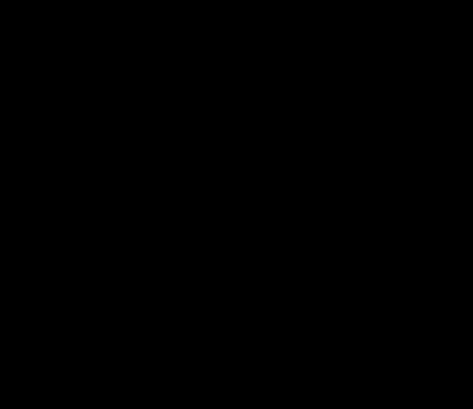

IMG_20240605_170847.jpg
IMG_20240605_170847.jpg
area 4.5
area 0.0
area 0.0
area 3.5
area 15.5
area 1.0
area 20.0
area 1.0
area 2.0
area 1.5
area 0.5
area 31.5
area 5.5
area 0.0
area 2.0
area 1.5
area 0.0
area 0.5
area 0.0
area 1.5
area 16.0
area 0.5
area 9.5
area 37.0
area 3.5
area 6.0
area 6.5
area 1.0
area 0.5
area 13.5
area 15.0
area 3.0
area 32.5
area 0.0
area 2.0
area 21.0
area 11.0
area 2.0
area 8.5
area 0.0
area 0.5
area 0.0
area 1.5
area 2.5
area 17.0
area 2.0
area 1.5
area 5.5
area 1.5
area 0.0
area 10.0
area 3.5
area 34.5
area 0.0
area 0.0
area 81.5
-65
area 4.5
area 27.0
area 93.0
-142
area 0.0
area 65.0
-144
area 9.5
area 24.0
area 5.5
area 28.0
area 2.5
area 3.0
area 2.0
area 4.0
area 1.5
area 1.0
area 0.5
area 0.0
area 20.0
area 1.5
area 39.5
area 0.5
area 5.0
area 0.0
area 0.0
area 43.0
-58
area 0.5
area 11.0
area 1.0
area 0.0
area 11.0
area 120.5
-61
area 3.5
area 7.5
area 41.0
-59
area 3.0
area 0.0
area 15.5
area 1.0
area 0.0
area 1.0
area 39.5
area 0.0
area 5.0
area 0

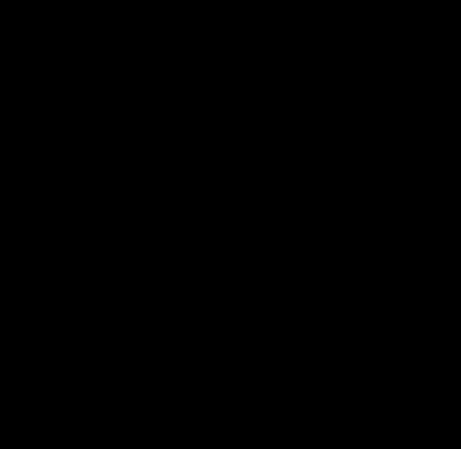

IMG_20240605_170849.jpg
IMG_20240605_170849.jpg
area 0.0
area 0.0
area 0.0
area 30.0
area 2.5
area 1.5
area 6.0
area 1.0
area 2.5
area 21.0
area 8.5
area 1.5
area 2.5
area 1.5
area 2.0
area 9.5
area 2.5
area 6.5
area 2.0
area 4.5
area 4.5
area 11.0
area 8.5
area 16.5
area 0.5
area 4.5
area 32.0
area 1.5
area 24.5
area 5.5
area 2.0
area 22.5
area 1.5
area 0.0
area 10.0
area 7.5
area 1.5
area 26.5
area 2.0
area 1.0
area 0.5
area 13.0
area 1.0
area 2.5
area 0.0
area 4.5
area 9.0
area 10.5
area 4.0
area 0.0
area 3.5
area 36.0
area 24.0
area 1.5
area 15.5
area 4.5
area 9.5
area 0.0
area 0.0
area 0.5
area 1.5
area 0.0
area 0.0
area 1.0
area 5.5
area 2.5
area 93.5
-137
area 26.5
area 2.0
area 24.5
area 0.5
area 29.0
area 28.0
area 8.5
area 63.0
-57
area 8.0
area 23.5
area 3.0
area 13.0
area 5.5
area 0.5
area 0.5
area 2.0
area 11.0
area 8.0
area 0.0
area 80.0
-57
area 14.0
area 7.5
area 1.5
area 1.0
area 40.5
-51
area 20.5
area 1.5
area 0.0
area 3.0
area 37.0
area 0.5
area 0.5
area 11.0
area 0

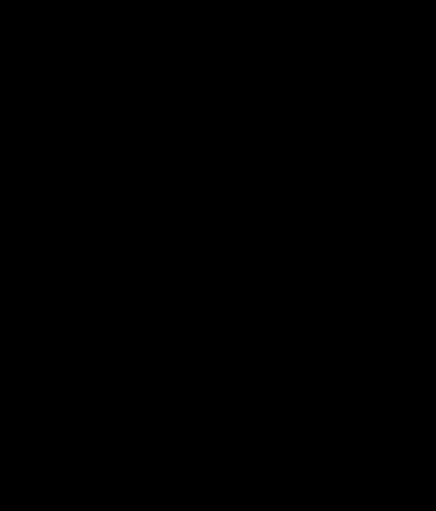

IMG_20240605_170851.jpg
IMG_20240605_170851.jpg
area 0.0
area 0.0
area 2.0
area 6.0
area 2.5
area 12.0
area 3.0
area 0.0
area 0.0
area 0.5
area 9.5
area 18.0
area 0.0
area 5.0
area 1.0
area 4.0
area 0.0
area 4.0
area 0.0
area 0.0
area 0.0
area 12.5
area 16.0
area 0.0
area 0.0
area 1.0
area 0.0
area 0.0
area 0.0
area 0.0
area 0.0
area 1.0
area 0.0
area 0.0
area 3.0
area 4.0
area 3.0
area 0.0
area 1.5
area 0.0
area 0.0
area 1.0
area 4.5
area 2.5
area 1.5
area 0.0
area 1.0
area 10.5
area 2.0
area 0.0
area 0.0
area 0.5
area 0.5
area 2.0
area 0.0
area 1.0
area 1.0
area 1.0
area 0.5
area 4.0
area 0.0
area 0.0
area 3.5
area 1.0
area 0.0
area 1.0
area 2.5
area 21.0
area 47.0
-103
area 1.5
area 0.5
area 7.0
area 0.0
area 26.5
area 1.5
area 0.0
area 0.5
area 0.0
area 3.0
area 2.5
area 2.0
area 3.0
area 18.0
area 1.0
area 1.0
area 1.0
area 7.5
area 1.0
area 2.5
area 2.5
area 1.0
area 0.0
area 0.0
area 2.0
area 0.0
area 0.5
area 18.5
area 0.0
area 2.0
area 0.0
area 2.5
area 0.5
area 0.5
area 0.0
a

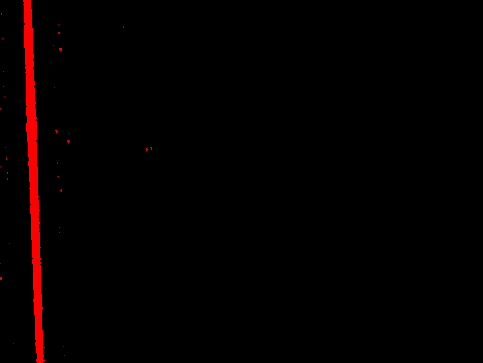

area 0.0
area 602.5
area 1143.0
area 927.0
area 3911.5
area 2801.0
destra identificata
IMG_20240605_170854.jpg
IMG_20240605_170854.jpg
area 0.0
area 10.0
area 0.5
area 5.0
area 19.5
area 21.0
area 6.0
area 13.5
area 6.0
area 4.5
area 15.0
area 7.0
area 1.0
area 7.0
area 1.5
area 17.0
area 23.5
area 8.0
area 8.0
area 8.0
area 0.0
area 14.5
area 6.0
area 0.0
area 1.5
area 0.0
area 0.5
area 75.0
-123
area 10.5
area 11.5
area 1.0
area 28.0
area 1.0
area 8.5
area 9.5
area 0.5
area 46.0
-64
area 5.5
area 108.5
-149
area 11.0
area 13.5
area 25.0
area 93.5
-62
area 17.0
area 1.0
area 121.0
-63
area 7.0
area 0.0
area 5.5
area 0.0
area 0.0
area 1.0
area 1.5
area 1.0
area 29.5
area 9.0
area 1.0
area 42.5
-99
area 99.5
-57
area 157.0
-60
area 3.0
area 1.5
area 18.0
area 0.0
area 0.0
area 1.0
area 6.0
area 1.5
area 0.0
area 3.0
area 1.5
area 8.0
area 0.0
area 3.5
area 3.5
area 2.0
area 40.5
-57
area 2.5
area 2.0
area 6.5
area 4.0
area 7.5
area 3.0
area 1.0
area 3.5
area 22.0
area 3.0
area 3.5
area 

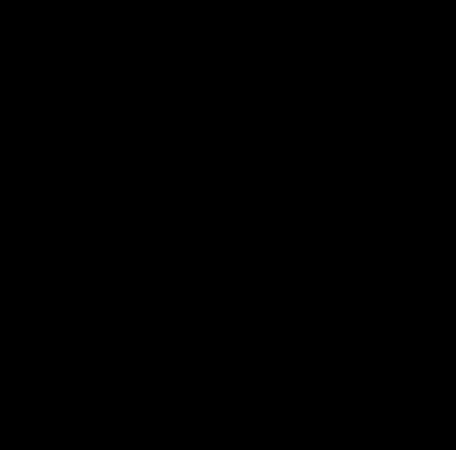

IMG_20240605_170856.jpg
IMG_20240605_170856.jpg
area 7.0
area 2.0
area 25.5
area 4.5
area 27.0
area 23.0
area 1.0
area 4.5
area 0.0
area 2.5
area 4.0
area 2.0
area 25.5
area 2.5
area 1.5
area 5.5
area 1.5
area 0.5
area 22.0
area 1.5
area 3.0
area 0.5
area 2.5
area 3.0
area 2.5
area 0.0
area 0.0
area 7.0
area 0.0
area 0.0
area 2.5
area 0.0
area 0.0
area 4.0
area 0.0
area 0.0
area 0.0
area 1.0
area 21.0
area 24.5
area 1.5
area 0.0
area 17.5
area 0.0
area 0.0
area 0.5
area 0.0
area 1.0
area 0.0
area 0.0
area 33.0
area 0.5
area 4.5
area 0.0
area 0.0
area 2.5
area 0.5
area 0.0
area 0.0
area 0.0
area 0.0
area 30.0
area 1.0
area 2.0
area 0.0
area 0.0
area 0.0
area 31.5
area 0.5
area 0.5
area 0.0
area 0.0
area 6.0
area 4.5
area 1.5
area 0.0
area 0.5
area 1.0
area 0.0
area 2.0
area 0.5
area 1.0
area 0.0
area 1.0
area 1.0
area 1.0
area 5.0
area 4.0
area 13.0
area 23.0
area 34.5
area 2.0
area 1.0
area 1.0
area 2.0
area 0.0
area 0.0
area 55.5
-206
area 2.0
area 1.5
area 0.0
area 2.0
area 3.5
area 

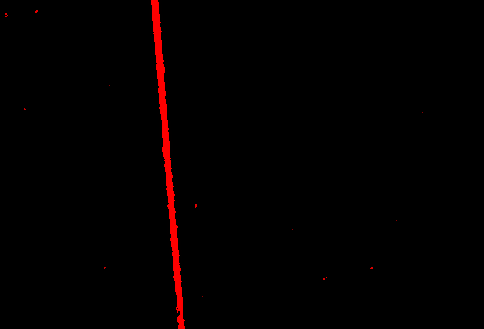

area 1046.5
area 987.0
area 958.0
area 897.0
area 897.0
area 897.0
area 957.0
area 897.0
area 679.0
area 0.0
area 1.0
destra identificata
IMG_20240605_170859.jpg
IMG_20240605_170859.jpg
area 2.5
area 0.0
area 3.5
area 2.0
area 1.5
area 5.0
area 1.5
area 16.5
area 1.5
area 8.0
area 8.0
area 0.0
area 4.0
area 0.5
area 0.0
area 33.5
area 4.5
area 2.5
area 5.0
area 1.5
area 14.0
area 1.5
area 1.0
area 3.0
area 1.0
area 7.0
area 15.5
area 35.5
area 5.5
area 0.0
area 11.0
area 0.5
area 26.5
area 1.0
area 2.5
area 6.5
area 13.0
area 14.0
area 3.5
area 2.5
area 42.5
-136
area 11.5
area 12.5
area 1.0
area 15.0
area 10.5
area 0.5
area 17.0
area 0.0
area 10.5
area 0.0
area 4.0
area 13.0
area 0.5
area 39.0
area 19.5
area 3.0
area 22.5
area 3.0
area 45.5
-55
area 4.0
area 4.5
area 2.5
area 1.5
area 7.5
area 30.0
area 2.5
area 27.0
area 0.0
area 11.5
area 20.0
area 10.5
area 13.5
area 0.5
area 2.0
area 11.0
area 7.0
area 6.5
area 0.5
area 3.5
area 10.0
area 3.5
area 1.5
area 4.5
area 0.0
area 6.0
ar

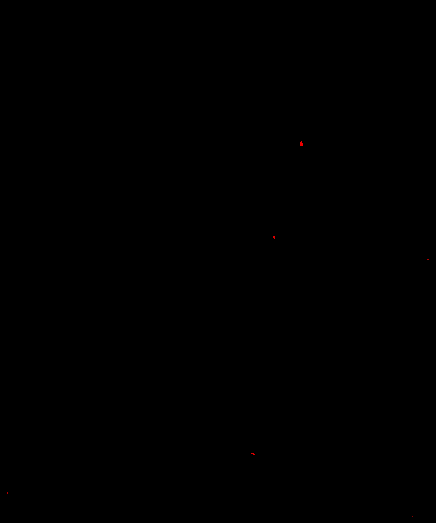

area 0.0
area 679.0
area 1017.5
area 0.0
area 988.0
area 1081.5
destra identificata
IMG_20240605_170901.jpg
IMG_20240605_170901.jpg
area 27.0
area 17.0
area 1.0
area 0.0
area 17.0
area 1.5
area 5.0
area 5.0
area 2.0
area 25.0
area 18.0
area 27.0
area 14.5
area 0.0
area 5.5
area 33.0
area 2.0
area 0.0
area 43.5
-114
area 1.0
area 0.0
area 0.5
area 1.5
area 1.0
area 4.0
area 0.5
area 0.0
area 0.0
area 3.5
area 2.5
area 0.0
area 0.0
area 0.0
area 0.5
area 1.0
area 0.0
area 0.0
area 52.0
-114
area 2.5
area 2.0
area 0.0
area 2.5
area 0.5
area 30.0
area 0.5
area 0.0
area 24.0
area 106.5
-115
area 3.0
area 1.0
area 0.0
area 1.0
area 3.0
area 6.5
area 0.0
area 1.5
area 20.5
area 18.5
area 0.0
area 0.5
area 17.0
area 2.0
area 4.5
area 49.0
-116
area 6.0
area 0.0
area 1.5
area 18.5
area 2.0
area 5.5
area 3.5
area 3.0
area 3.5
area 1.0
area 0.0
area 0.0
area 0.5
area 0.5
area 28.5
area 0.0
area 21.5
area 16.0
area 0.0
area 5.0
area 3.5
area 0.5
area 1.5
area 0.0
area 2.5
area 2.5
area 31.5
area 1

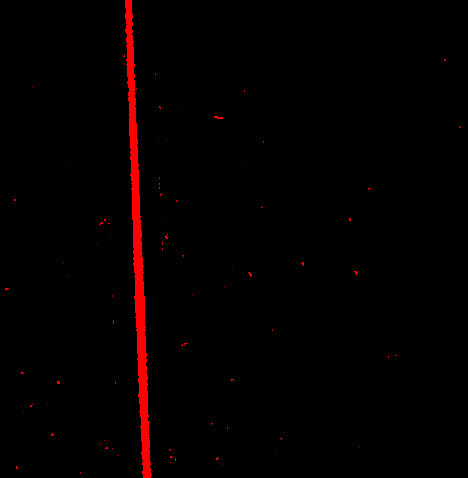

area 0.5
area 897.0
area 1458.5
area 2489.5
area 989.0
area 4584.0
area 1190.5
area 1137.5
area 927.0
area 897.0
area 710.0
area 1080.5
area 1114.0
area 1329.0
area 1048.5
area 927.0
area 927.0
area 1969.0
area 897.0
area 1764.5
area 0.0
area 2070.0
area 897.0
area 958.0
area 3116.0
area 2917.0
destra identificata
IMG_20240605_170905.jpg
IMG_20240605_170905.jpg
area 2.0
area 1.5
area 1.0
area 0.0
area 35.5
area 3.0
area 0.0
area 1.5
area 0.0
area 1.5
area 0.0
area 9.5
area 0.0
area 1.5
area 2.0
area 1.5
area 3.0
area 1.0
area 2.0
area 2.5
area 1.0
area 1.5
area 12.0
area 9.0
area 5.0
area 35.0
area 0.0
area 6.0
area 6.5
area 9.0
area 2.0
area 4.0
area 5.0
area 0.5
area 10.5
area 21.0
area 7.0
area 3.0
area 4.5
area 0.0
area 11.5
area 0.0
area 0.5
area 4.0
area 42.0
-78
area 8.0
area 0.0
area 7.0
area 0.0
area 3.5
area 1.0
area 4.5
area 0.5
area 4.5
area 0.0
area 0.0
area 1.0
area 7.0
area 0.5
area 0.5
area 3.0
area 0.0
area 0.0
area 2.0
area 0.0
area 2.0
area 6.5
area 0.0
area 59.5
-78

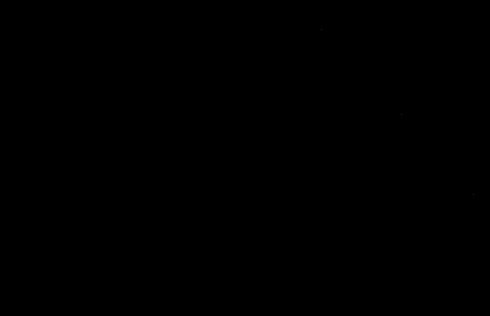

area 897.0
area 897.0
area 897.0
destra identificata
IMG_20240605_170907.jpg
IMG_20240605_170907.jpg
area 2.5
area 0.0
area 2.5
area 2.0
area 5.5
area 0.0
area 9.0
area 25.5
area 2.0
area 13.5
area 2.0
area 6.0
area 11.5
area 2.0
area 0.0
area 0.0
area 3.0
area 63.5
-115
area 36.0
area 0.0
area 2.5
area 15.5
area 25.5
area 8.5
area 36.0
area 4.5
area 2.5
area 5.0
area 6.5
area 25.5
area 28.5
area 4.0
area 0.0
area 5.0
area 6.0
area 0.0
area 1.0
area 1.5
area 18.5
area 89.0
-119
area 16.0
area 1.0
area 13.0
area 16.5
area 24.5
area 5.0
area 0.5
area 2.0
area 57.0
-207
area 3.5
area 0.0
area 1.0
area 4.0
area 20.0
area 1.5
area 4.5
area 0.0
area 4.0
area 26.5
area 57.5
-223
area 24.5
area 42.5
-216
area 0.5
area 0.0
area 0.0
area 32.0
area 4.0
area 0.0
area 1.0
area 0.0
area 1.5
area 0.5
area 23.0
area 2.0
area 2.5
area 0.5
area 7.5
area 1.0
area 0.0
area 5.5
area 14.5
area 3.5
area 19.5
area 0.5
area 0.0
area 0.0
area 5.0
area 1.0
area 7.0
area 2.5
area 0.5
area 2.0
area 3.0
area 1.5
ar

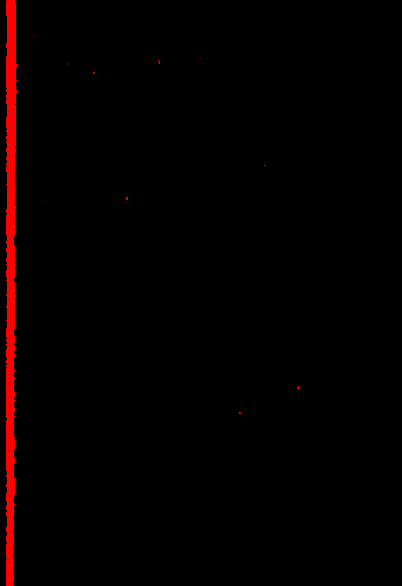

area 958.0
area 1018.0
area 989.0
area 927.0
area 1800.0
area 1016.5
area 897.0
area 1442.0
area 0.0
destra identificata
IMG_20240605_170910.jpg
IMG_20240605_170910.jpg
area 19.0
area 77.0
-88
area 3.5
area 0.0
area 3.5
area 2.5
area 1.0
area 0.5
area 0.5
area 5.0
area 2.0
area 2.5
area 2.5
area 0.5
area 1.5
area 2.0
area 0.5
area 8.0
area 9.0
area 4.5
area 9.0
area 0.5
area 1.0
area 17.5
area 0.0
area 18.5
area 2.5
area 0.0
area 2.5
area 20.5
area 0.0
area 1.0
area 12.0
area 0.0
area 0.0
area 0.5
area 0.0
area 0.0
area 18.5
area 1.0
area 20.5
area 3.0
area 0.5
area 0.0
area 0.0
area 0.0
area 0.0
area 1.0
area 0.5
area 0.5
area 8.5
area 0.0
area 0.5
area 1.5
area 0.0
area 1.0
area 2.0
area 0.0
area 0.5
area 16.0
area 0.0
area 0.0
area 1.0
area 3.0
area 14.0
area 0.0
area 2.0
area 2.0
area 0.0
area 2.0
area 2.5
area 0.0
area 22.5
area 3.5
area 0.5
area 0.5
area 1.0
area 2.0
area 0.0
area 1.5
area 0.0
area 1.5
area 0.5
area 30.5
area 2.5
area 2.0
area 27.0
area 4.0
area 19.0
area 3.5
are

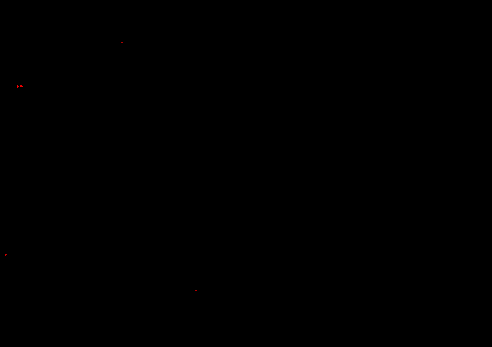

area 927.0
area 648.0
area 1112.5
area 927.0
destra identificata


In [89]:
import os
path='/content/mio/crops/destra/'
path2='/content/'
file_lista = os.listdir('/content/mio/crops/destra/')
file_lista.sort()
print(file_lista)
file_lista_filtrata = []

for file in file_lista:
  if not file.endswith(".ipynb_checkpoints"):
    file_lista_filtrata.append(file)

# Ordina l'elenco dei file filtrati in ordine alfabetico
file_lista_filtrata.sort()
nome_file = "risultati.txt"
  # Cicla su ogni file nella cartella.
with open(os.path.join(path2, nome_file), 'w') as file2:
 for file in file_lista_filtrata:

  print(file)
  immagine = cv2.imread(os.path.join(path, file))
 #immagine2 = cv2.imread('/content/support/immagine_ruotata.jpg')
  print(file)
  img_edge=layer_2_direction(immagine)
  angolo=find_angolo(img_edge)
  pezzo_ruotato=ruota_pezzo(immagine,angolo)
  dilatato=dilata()
  centrato=centra_pezzo()
  fixato=fix_pezzo(centrato)
  ritaglio_dx=ritaglia_alto_dx(fixato)
  ritaglio_sx=ritaglia_basso_sx(fixato)
  an_sx=analisi_basso_sx(ritaglio_sx)
  id=tacca_basso_sx(an_sx)
  an_dx=analisi_alto_dx(ritaglio_dx)
  id2=tacca_alto_dx(an_dx)

  if id==0 and id2==0:
   file2.write(file+'-'+'pezzo sinistro' + '\n')
  else:
   file2.write(file+'-'+'pezzo destro' + '\n')

 file2.close()